In [64]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import scipy
import scipy.io as sio
import scikits.bootstrap as bootstrap
from necessary_analysis_scripts import prettify_plot, bar_witherror_anddots
from necessary_analysis_scripts import calculate_aprime, resampling_statistics, test_normality, run_stats
import pandas as pd
from scipy.stats import ttest_1samp
from scipy.stats import spearmanr

# Plotting defaults

In [65]:
#plot within jupyter notebooks
%matplotlib inline 

#tab completion for files
%config IPCompleter.greedy=True 

#supress scientific notation
np.set_printoptions(suppress=True) 

#font defaults
plt.rcParams.update({'font.size': 24})
rc('text', usetex=False)
plt.rcParams['pdf.fonttype'] = 42

#plot title fonts
if os.path.isfile("/Library/Fonts/HelveticaNeue.ttf"): titleprop = fm.FontProperties(fname="/Library/Fonts/HelveticaNeue.ttf",size=30)
else: titleprop = fm.FontProperties(size=30)

#colors
col_cue = (60/255.,83/255.,164/255.)
col_uncue = (219/255.,11/255.,132/255.)
col_cueunprobed = (5/255.,126/255.,143/255.)
col_neut = (0.,220./255,104./255)
col_cue_acc = [6/255.,0,128/255.]
col_cue_inacc = [157/255.,153/255.,255/255.]
col_uncue_acc = [128/255.,13/255.,86/255.]
col_uncue_inacc = [255/255.,163/255.,221/255.]
col_cueunprobe_acc = [4/255.,95/255.,107/255.]
col_cueunprobe_inacc = [155/255.,203/255.,210/255.]

# Project information

In [66]:
#project details
nb = 16                     #number of blocks
nt_wm_perblock = 24         #number of working memory trials per block
nt_ltm_perblock = 60        #number of long-term memory trials per block
nt_wm = nb*nt_wm_perblock   #total number of working memory trials
nt_ltm = nb*nt_ltm_perblock #total number of long-term memory trials

#statistics
n_its = 100000              #number of iterations for statistics

#binning analysis
nbins=8                     #number of bins for binning analysis (octiles)

# Experiment 1a

In [67]:
exp_name = 'expt1a'
exp_dir_1a = '../' + exp_name + '/'

subj_name_1a = ['0419171_rtPreStim01','0419172_rtPreStim01','0421171_rtPreStim01',
             '0421172_rtPreStim01','0421173_rtPreStim01','0424171_rtPreStim01',
             '0424172_rtPreStim01','0428171_rtPreStim01','0428172_rtPreStim01',
             '0501171_rtPreStim01','0501173_rtPreStim01','0503171_rtPreStim01',
             '0503172_rtPreStim01','0503173_rtPreStim01','0505171_rtPreStim01',
             '0505172_rtPreStim01','0505175_rtPreStim01','0508171_rtPreStim01',
             '0508172_rtPreStim01','0508173_rtPreStim01','0515171_rtPreStim01',
             '0522171_rtPreStim01','0526171_rtPreStim01']
nsubj = np.size(subj_name_1a)

#load files
dat_wm_1a = {}
dat_ltm_1a = {}
nt_completed = np.empty(nsubj)
for isubj in range(nsubj):
    dat_wm_1a[isubj] = pd.read_csv(exp_dir_1a + subj_name_1a[isubj] +'_wmlog.csv')
    dat_ltm_1a[isubj] = pd.read_csv(exp_dir_1a + subj_name_1a[isubj] +'_ltmlog.csv')
    nt_completed[isubj] = np.shape(dat_wm_1a[isubj])[0]
    
print('# subjects = %d' %nsubj)
print("Avg percent completed %.2f" % (np.round(np.mean(nt_completed/nt_wm)*100,decimals=2)))
print("Range of trials completed %i (min) - %i (max)" %(np.min(nt_completed),np.max(nt_completed)))

# subjects = 23
Avg percent completed 89.95
Range of trials completed 240 (min) - 384 (max)


## Location memory response error

In [68]:
#preallocate empty matrices
resperr_ltm_all = []
resperr_ltm_mean = np.empty(nsubj)
resperr_wm_mean = np.empty(nsubj)

for isubj in range(nsubj):    
    #ltm
    resperr_ltm = dat_ltm_1a[isubj]['ltmresptestimgdiff'][np.logical_or(dat_ltm_1a[isubj]['ltmTrialsOldValidCued']==1,
                                                           dat_ltm_1a[isubj]['ltmTrialsOldInvalidTested']==1)]
    resperr_ltm_all = np.append(resperr_ltm_all,resperr_ltm) #include data from this subject in aggregate data
    resperr_ltm_mean[isubj] = np.mean(np.abs(resperr_ltm))

    #wm
    resperr_wm = dat_wm_1a[isubj]['wmresptestimgdiff']
    resperr_wm_mean[isubj] = np.mean(np.abs(resperr_wm))

#print mean, CIs
print("Mean LTM response error: ", np.round(np.mean(resperr_ltm_mean),decimals=2),np.round(bootstrap.ci(data=(resperr_ltm_mean), n_samples=n_its),decimals=2))
print("Mean WM response error: ", np.round(np.mean(resperr_wm_mean),decimals=2),np.round(bootstrap.ci(data=(resperr_wm_mean), n_samples=n_its),decimals=2))


Mean LTM response error:  61.0 [54.41 66.87]
Mean WM response error:  18.86 [16.12 23.19]


## Relating long-term memory to working memory


In [69]:
#preallocate
cuedvalidly_bin = np.zeros((nsubj,nbins))
resperr_wm_bin = np.zeros((nsubj,nbins))
resperr_ltm_bin = np.zeros((nsubj,nbins))
cuedvalidly = []
wmdiff = []
ltmdiff = []

for isubj in range(nsubj):
    
    #append all trials
    cuedvalidly.append(np.zeros(np.sum(np.logical_or(dat_ltm_1a[isubj].conditionNum==1,dat_ltm_1a[isubj].conditionNum==3))))
    wmdiff.append(np.zeros(np.sum(np.logical_or(dat_ltm_1a[isubj].conditionNum==1,dat_ltm_1a[isubj].conditionNum==3))))
    ltmdiff.append(np.zeros(np.sum(np.logical_or(dat_ltm_1a[isubj].conditionNum==1,dat_ltm_1a[isubj].conditionNum==3))))
        
    count = 0
    for iblock in np.unique(dat_ltm_1a[isubj].block):
        #find trials from this block
        itrials_wm = dat_wm_1a[isubj].block==iblock
        itrials_ltm = np.logical_and(dat_ltm_1a[isubj].block==iblock,np.logical_or(dat_ltm_1a[isubj].conditionNum==1,dat_ltm_1a[isubj].conditionNum==3))

        #find response error for this block's trials
        cuevalid = np.ravel(dat_wm_1a[isubj].cuevalid[itrials_wm])
        respdiff_wm = np.abs(np.ravel(dat_wm_1a[isubj].wmresptestimgdiff[itrials_wm]))
        respdiff_ltm = np.abs(np.ravel(dat_ltm_1a[isubj].ltmresptestimgdiff[itrials_ltm]))
        wmtrialnum_wm = np.ravel(dat_wm_1a[isubj].trial[itrials_wm])
        wmtrialnum_ltm = np.ravel(dat_ltm_1a[isubj].ltmWMtrialNum[itrials_ltm])

        #reorder LTM difference according to wm encoding order
        for itrial in range(np.size(wmtrialnum_ltm)):
            i = np.where(wmtrialnum_wm==wmtrialnum_ltm[itrial])[0]
            cuedvalidly[isubj][count] =(cuevalid[i])
            wmdiff[isubj][count] =(respdiff_wm[i])
            ltmdiff[isubj][count]=(respdiff_ltm[itrial])
            count=count+1
    
    #calculate mean response error in the WM phase
    temp_perc = (np.percentile(ltmdiff[isubj],np.linspace(0,100,(nbins+1),endpoint=True)))
    
    for i,iperc in enumerate(temp_perc[1:]):
        cuedvalidly_bin[isubj,i]=np.mean(cuedvalidly[isubj][np.logical_and(ltmdiff[isubj]<iperc,ltmdiff[isubj]>temp_perc[i])])
        resperr_wm_bin[isubj,i]=np.mean(wmdiff[isubj][np.logical_and(ltmdiff[isubj]<iperc,ltmdiff[isubj]>temp_perc[i])])
        resperr_ltm_bin[isubj,i]= np.mean(ltmdiff[isubj][np.logical_and(ltmdiff[isubj]<iperc,ltmdiff[isubj]>temp_perc[i])])


In [70]:
# trial-wise correlations

r = np.empty(nsubj)
m = np.empty(nsubj)
for isubj in range(nsubj):
    r[isubj],p = (pearsonr(wmdiff[isubj],ltmdiff[isubj]))
    m[isubj],_ = np.polyfit(wmdiff[isubj],ltmdiff[isubj],1)

p,_ = resampling_statistics(r,0)
print(np.mean(r,axis=0),bootstrap.ci(data=(r), statfunction=scipy.mean,n_samples=n_its),p) 
p,_ = resampling_statistics(m,0)
print(np.mean(m,axis=0),bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=n_its),p)

0.18683385207915967 [0.14618406 0.23412537] 1e-05
0.2995044310593497 [0.2306515  0.37228465] 1e-05


In [71]:
#binning analysis
pfit = np.zeros((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(np.arange(nbins),resperr_wm_bin[isubj,:],1)
print('Sustained attention slope, mean', np.round(np.mean(pfit[:,0],axis=0),decimals=2))
print('Sustained attention slope, CIs', np.round(bootstrap.ci(data=(pfit[:,0]), statfunction=scipy.mean,n_samples=n_its),decimals=2))
print('Sustained attention slope, stats', resampling_statistics(pfit[:,0],0))

Sustained attention slope, mean 2.71
Sustained attention slope, CIs [2.12 3.46]
Sustained attention slope, stats (1e-05, array([2.46999963, 3.24562698, 2.51179073, ..., 2.37055984, 3.26535238,
       2.24143844]))


## Spatial attention results

If cues influence long-term memory, then the response error will be lower for cued vs. uncued items

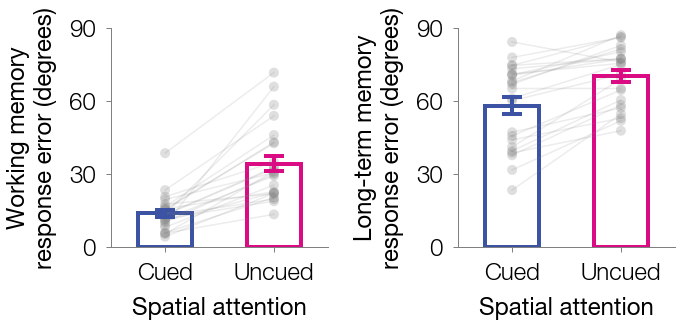

Mean response error:
wm cued:	 13.74 [11.38 17.61]
wm uncued:	 34.21 [28.75 41.52]
ltm cued:	 57.95 [50.65 64.31]
ltm uncued:	 70.14 [65.01 74.71]

Working memory: cued vs uncued
Wilcoxon: t  0.0 p 2.7015948487105512e-05
p:  1e-05
1e-05

Long-term memory: cued vs uncued
Wilcoxon: t  7.0 p 6.766255368658355e-05
p:  1e-05
1e-05


In [72]:
#preallocate empty matrices
resperr_wm_cue_mean,resperr_wm_uncue_mean = np.empty(nsubj),np.empty(nsubj)
resperr_ltm_cue_mean,resperr_ltm_uncue_mean = np.empty(nsubj),np.empty(nsubj)

for isubj in range(nsubj):
    #wm, cued
    resperr_wm_cue = dat_wm_1a[isubj]['wmresptestimgdiff'][dat_wm_1a[isubj]['cuevalid']==1]
    resperr_wm_cue_mean[isubj] = np.mean(np.abs(resperr_wm_cue))
    
    #wm, uncued
    resperr_wm_uncue = dat_wm_1a[isubj]['wmresptestimgdiff'][dat_wm_1a[isubj]['cuevalid']==0] 
    resperr_wm_uncue_mean[isubj] = np.mean(np.abs(resperr_wm_uncue))
    
    #ltm, cued
    resperr_ltm_cue = dat_ltm_1a[isubj]['ltmresptestimgdiff'][dat_ltm_1a[isubj]['ltmTrialsOldValidCued']==1]
    resperr_ltm_cue_mean[isubj] = np.mean(np.abs(resperr_ltm_cue))
    
    #ltm, uncued
    resperr_ltm_uncue = dat_ltm_1a[isubj]['ltmresptestimgdiff'][dat_ltm_1a[isubj]['ltmTrialsOldInvalidTested']==1] 
    resperr_ltm_uncue_mean[isubj] = np.mean(np.abs(resperr_ltm_uncue))

#plot
fig,ax = plt.subplots(1,2,figsize=(10,5))
bar_witherror_anddots(ax[0],resperr_wm_cue_mean,resperr_wm_uncue_mean,c0=col_cue,c1=col_uncue)
prettify_plot(ax[0],ylrot=0,xlim=(-.5,1.5),
                 xt=([0,1]),xtl=(['Cued','Uncued']),xl='Spatial attention',yl='Working memory\nresponse error (degrees)',
                 yt=([0,30,60,90]),ytl=([0,30,60,90]),ylim=(0,90))

bar_witherror_anddots(ax[1],resperr_ltm_cue_mean,resperr_ltm_uncue_mean,c0=col_cue,c1=col_uncue)
prettify_plot(ax[1],ylrot=0,xlim=(-.5,1.5),
                 xt=([0,1]),xtl=(['Cued','Uncued']),xl='Spatial attention',yl='Long-term memory\nresponse error (degrees)',
                 yt=([0,30,60,90]),ytl=([0,30,60,90]),ylim=(0,90))
plt.show()

#print
print("Mean response error:")
print("wm cued:\t", np.round(np.mean(resperr_wm_cue_mean),decimals=2),np.round(bootstrap.ci(data=(resperr_wm_cue_mean), n_samples=n_its),decimals=2))
print("wm uncued:\t",np.round(np.mean(resperr_wm_uncue_mean),decimals=2),np.round(bootstrap.ci(data=(resperr_wm_uncue_mean), n_samples=n_its),decimals=2))

print("ltm cued:\t", np.round(np.mean(resperr_ltm_cue_mean),decimals=2),np.round(bootstrap.ci(data=(resperr_ltm_cue_mean), n_samples=n_its),decimals=2))
print("ltm uncued:\t",np.round(np.mean(resperr_ltm_uncue_mean),decimals=2),np.round(bootstrap.ci(data=(resperr_ltm_uncue_mean), n_samples=n_its),decimals=2))

print('\nWorking memory: cued vs uncued')#wm cued vs. uncued
p = run_stats(resperr_wm_uncue_mean,resperr_wm_cue_mean)
print(p)

print('\nLong-term memory: cued vs uncued')#ltm cued vs. uncued
p = run_stats(resperr_ltm_uncue_mean,resperr_ltm_cue_mean)
print(p)

In [73]:
#Calculate slope of proportion cued

pfit = np.zeros((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(np.arange(nbins),cuedvalidly_bin[isubj,:],1)
print('LTM to spatial attn, mean', np.round(np.mean(pfit[:,0],axis=0),decimals=2),np.round(bootstrap.ci(data=(pfit[:,0]),n_samples=n_its),decimals=2))

#statistics
p, _ = resampling_statistics(-1*pfit[:,0],0)
print('LTM to spatial attn, stats', p)

LTM to spatial attn, mean -0.02 [-0.03 -0.01]
LTM to spatial attn, stats 1e-05


## Plot results for all trials


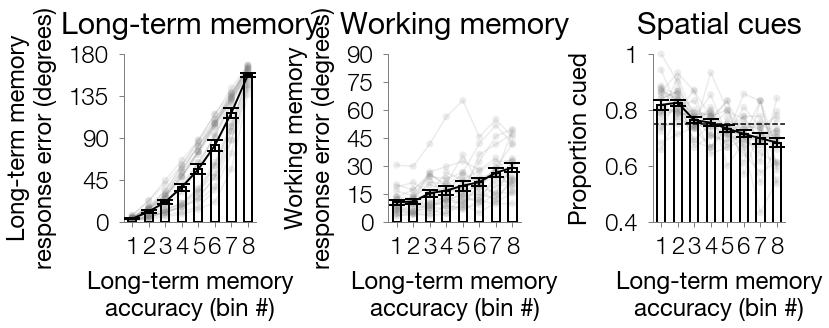

In [74]:
#make figure
fig,ax = plt.subplots(1,3,figsize=(12,5))

s=50
a=.15
#plot ltm 
nbins = np.shape(resperr_ltm_bin)[1]
for ibin in range(nbins):
    ax[0].scatter(np.zeros(nsubj)+ibin,resperr_ltm_bin[:,ibin],s=s,facecolor='gray',edgecolor='None',alpha=a)
ax[0].plot(np.arange(nbins),resperr_ltm_bin.T,color='gray',alpha=a)
ax[0].bar(np.arange(nbins),np.mean(resperr_ltm_bin,axis=0),.5,linewidth=2,facecolor='None',edgecolor='k',zorder=100)
ax[0].errorbar(np.arange(nbins),np.mean(resperr_ltm_bin,axis=0),np.std(resperr_ltm_bin,axis=0)/np.sqrt(nsubj),color='k',
                lw=2,capsize=8,capthick=2,zorder=100)

#plot working memory
for ibin in range(nbins):
    ax[1].scatter(np.zeros(nsubj)+ibin,resperr_wm_bin[:,ibin],s=s,facecolor='gray',edgecolor='None',alpha=a)
ax[1].plot(np.arange(nbins),resperr_wm_bin.T,color='gray',alpha=a)
ax[1].bar(np.arange(nbins),np.mean(resperr_wm_bin,axis=0),.5,linewidth=2,facecolor='None',edgecolor='k',zorder=100)
ax[1].errorbar(np.arange(nbins),np.mean(resperr_wm_bin,axis=0),np.std(resperr_wm_bin,axis=0)/np.sqrt(nsubj),color='k',
                lw=2,capsize=8,capthick=2,zorder=100)

#plot cued proportion 
for ibin in range(nbins):
    ax[2].scatter(np.zeros(nsubj)+ibin,cuedvalidly_bin[:,ibin],s=s,facecolor='gray',edgecolor='None',alpha=a,clip_on=False)
ax[2].plot(np.arange(nbins),cuedvalidly_bin.T,color='gray',alpha=a)
ax[2].bar(np.arange(nbins),np.mean(cuedvalidly_bin,axis=0),.5,linewidth=2,facecolor='None',edgecolor='k',zorder=100)
ax[2].errorbar(np.arange(nbins),np.mean(cuedvalidly_bin,axis=0),np.std(cuedvalidly_bin,axis=0)/np.sqrt(nsubj),color='k',
                lw=2,capsize=8,capthick=2,zorder=100)
ax[2].plot([-.5,nbins+.5],[.75,.75],'--',color='k')

prettify_plot(ax[0],ylrot=0,xlim=(-.5,nbins-.5),ylim=(0,180),
                 xt=(np.arange(nbins)),xtl=(np.arange(nbins)+1),
                 xl='Long-term memory\naccuracy (bin #)',yl='Long-term memory\nresponse error (degrees)',
                 yt=([0,45,90,135,180]),ytl=([0,45,90,135,180]))

prettify_plot(ax[1],ylrot=0,xlim=(-.5,nbins-.5),ylim=(0,90),
                 xt=(np.arange(nbins)),xtl=(np.arange(nbins)+1),
                 xl='Long-term memory\naccuracy (bin #)',yl='Working memory\nresponse error (degrees)',
                 yt=([0,15,30,45,60,75,90]),ytl=([0,15,30,45,60,75,90]))

prettify_plot(ax[2],ylrot=0,xlim=(-.5,nbins-.5),ylim=(.4,1),
                 xt=(np.arange(nbins)),xtl=(np.arange(nbins)+1),
                 xl='Long-term memory\naccuracy (bin #)',yl='Proportion cued',
                 yt=([.4,.6,.8,1]),ytl=([.4,.6,.8,1]))

ax[0].set_title('Long-term memory',fontproperties=titleprop,pad=20)
ax[1].set_title('Working memory',fontproperties=titleprop,pad=20)
ax[2].set_title('Spatial cues',fontproperties=titleprop,pad=20)

fig.subplots_adjust(wspace=1)
plt.show()



## Cued items only

Next, we want to control for the effects of spatial attention. Here we examine trial by trial fluctuations of sustained attention, controlling for spatial attention by examining the cued items only

In [75]:
#preallocate
cuedvalidly_cued_bin = np.zeros((nsubj,nbins))
resperr_wm_cued_bin = np.zeros((nsubj,nbins))
resperr_ltm_cued_bin = np.zeros((nsubj,nbins))
wmdiff_cued = []
ltmdiff_cued = []
cuevalid_cued = []

for isubj in range(nsubj):
    
    #append extra zeros for all trials
    cuevalid_cued.append(np.zeros(np.sum(dat_ltm_1a[isubj].conditionNum==1)))
    wmdiff_cued.append(np.zeros(np.sum(dat_ltm_1a[isubj].conditionNum==1)))
    ltmdiff_cued.append(np.zeros(np.sum(dat_ltm_1a[isubj].conditionNum==1)))
        
    count = 0
    for iblock in np.unique(dat_ltm_1a[isubj].block):
        #find trials from this block
        itrials_wm = np.logical_and(dat_wm_1a[isubj].block==iblock,dat_wm_1a[isubj].cuevalid==1)
        itrials_ltm = np.logical_and(dat_ltm_1a[isubj].block==iblock,dat_ltm_1a[isubj].conditionNum==1)

        #find response error for this block's trials
        cuevalid = np.ravel(dat_wm_1a[isubj].cuevalid[itrials_wm])
        respdiff_wm = np.abs(np.ravel(dat_wm_1a[isubj].wmresptestimgdiff[itrials_wm]))
        respdiff_ltm = np.abs(np.ravel(dat_ltm_1a[isubj].ltmresptestimgdiff[itrials_ltm]))
        wmtrialnum_wm = np.ravel(dat_wm_1a[isubj].trial[itrials_wm])
        wmtrialnum_ltm = np.ravel(dat_ltm_1a[isubj].ltmWMtrialNum[itrials_ltm])

        for itrial in range(np.size(wmtrialnum_ltm)):
            i = np.where(wmtrialnum_wm==wmtrialnum_ltm[itrial])[0]
            cuevalid_cued[isubj][count] =(cuevalid[i])
            wmdiff_cued[isubj][count] =(respdiff_wm[i])
            ltmdiff_cued[isubj][count]=(respdiff_ltm[itrial])
            count=count+1
    
    #calculate mean response error in the WM phase
    temp_perc = (np.percentile(ltmdiff_cued[isubj],np.linspace(0,100,(nbins+1),endpoint=True)))
    
    for i,iperc in enumerate(temp_perc[1:]):
        cuedvalidly_cued_bin[isubj,i]=np.mean(cuevalid_cued[isubj][np.logical_and(ltmdiff_cued[isubj]<iperc,ltmdiff_cued[isubj]>temp_perc[i])])
        resperr_wm_cued_bin[isubj,i]=np.mean(wmdiff_cued[isubj][np.logical_and(ltmdiff_cued[isubj]<iperc,ltmdiff_cued[isubj]>temp_perc[i])])
        resperr_ltm_cued_bin[isubj,i]= np.mean(ltmdiff_cued[isubj][np.logical_and(ltmdiff_cued[isubj]<iperc,ltmdiff_cued[isubj]>temp_perc[i])])

In [76]:
#trial-wise correlations

r = np.empty(nsubj)
m = np.empty(nsubj)
for isubj in range(nsubj):
    r[isubj],p = (pearsonr(wmdiff_cued[isubj],ltmdiff_cued[isubj]))
    m[isubj],_ = np.polyfit(wmdiff_cued[isubj],ltmdiff_cued[isubj],1)


p,_ = resampling_statistics(r,0)
print(np.mean(r,axis=0),bootstrap.ci(data=(r), statfunction=scipy.mean,n_samples=n_its),p) 
p,_ = resampling_statistics(m,0)
print(np.mean(m,axis=0),bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=n_its),p)

0.15219634021816048 [0.11748893 0.19694374] 1e-05
0.29113664862937744 [0.22781278 0.35834439] 1e-05


In [77]:
#binning analysis
pfit = np.zeros((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(np.arange(nbins),resperr_wm_cued_bin[isubj,:],1)

print(np.round(np.mean(pfit[:,0],axis=0),decimals=2),np.round(bootstrap.ci(data=(pfit[:,0]), n_samples=n_its),decimals=2))
p,_ = resampling_statistics(pfit[:,0],0)
print("stats", p)

2.02 [1.5  2.79]
stats 1e-05


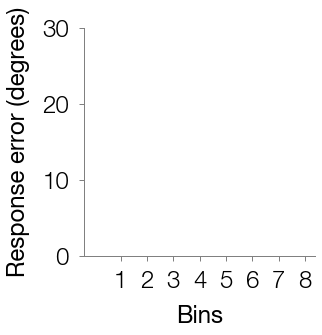

In [78]:


fig,ax = plt.subplots(1,1,figsize=(5,5))

prettify_plot(ax,xt=np.arange(nbins)+1,xtl=np.arange(nbins)+1,
             ylim=[0,30],yt=[0,10,20,30],ytl=[0,10,20,30],
             yl='Response error (degrees)',xl='Bins')

## Binning analysis, uncued items only

Then, we repeat this analysis to examine trial by trial fluctuations of sustained attention, controlling for spatial attention by examining the uncued items only

In [79]:
#preallocate
cuedvalidly_uncued_bin = np.zeros((nsubj,nbins))
resperr_wm_uncued_bin = np.zeros((nsubj,nbins))
resperr_ltm_uncued_bin = np.zeros((nsubj,nbins))
wmdiff_uncued = []
ltmdiff_uncued = []
cuevalid_uncued = []
#degdiff_uncued = []
ltmdiff_origcued_uncued = []
#degdiff_uncued_bin = np.zeros((nsubj,nbins))
resperr_ltm_origcued_uncued_bin = np.zeros((nsubj,nbins))

for isubj in range(nsubj):
    
    #append extra zeros for all trials
    cuevalid_uncued.append(np.zeros(np.sum(dat_ltm_1a[isubj].conditionNum==3)))
    wmdiff_uncued.append(np.zeros(np.sum(dat_ltm_1a[isubj].conditionNum==3)))
    ltmdiff_uncued.append(np.zeros(np.sum(dat_ltm_1a[isubj].conditionNum==3)))
    #degdiff_uncued.append(np.zeros(np.sum(dat_ltm_1a[isubj].conditionNum==3)))
    ltmdiff_origcued_uncued.append(np.zeros(np.sum(dat_ltm_1a[isubj].conditionNum==3)))
    
    count = 0
    for iblock in np.unique(dat_ltm_1a[isubj].block):
        #find trials from this block
        itrials_wm = np.logical_and(dat_wm_1a[isubj].block==iblock,dat_wm_1a[isubj].cuevalid==0)
        itrials_ltm = np.logical_and(dat_ltm_1a[isubj].block==iblock,dat_ltm_1a[isubj].conditionNum==3)
        itrials_origcued_ltm = np.logical_and(dat_ltm_1a[isubj].block==iblock,dat_ltm_1a[isubj].conditionNum==2)
        
        #find response error for this block's trials
        cuevalid = np.ravel(dat_wm_1a[isubj].cuevalid[itrials_wm])
        respdiff_wm = np.abs(np.ravel(dat_wm_1a[isubj].wmresptestimgdiff[itrials_wm]))
        respdiff_ltm = np.abs(np.ravel(dat_ltm_1a[isubj].ltmresptestimgdiff[itrials_ltm]))
        respdiff_ltm_origcued = np.abs(np.ravel(dat_ltm_1a[isubj].ltmresptestimgdiff[itrials_origcued_ltm]))
        wmtrialnum_wm = np.ravel(dat_wm_1a[isubj].trial[itrials_wm])
        wmtrialnum_ltm = np.ravel(dat_ltm_1a[isubj].ltmWMtrialNum[itrials_ltm])
        wmtrialnum_ltm_origcued = np.ravel(dat_ltm_1a[isubj].ltmWMtrialNum[itrials_origcued_ltm])
        
        #x=dat_wm_1a[isubj].imageposdeg0[itrials_wm]
        #y=dat_wm_1a[isubj].imageposdeg1[itrials_wm]
        #degdiff = np.ravel(np.degrees(np.arctan2(np.sin(np.radians(x-y)), np.cos(np.radians(x-y)))))
        
        for itrial in range(np.size(wmtrialnum_ltm)):
            i = np.where(wmtrialnum_wm==wmtrialnum_ltm[itrial])[0]
            cuevalid_uncued[isubj][count] =(cuevalid[i])
            wmdiff_uncued[isubj][count] =(respdiff_wm[i])
            ltmdiff_uncued[isubj][count]=(respdiff_ltm[itrial])
            #degdiff_uncued[isubj][count]=(degdiff[i])
            
            i2 = np.where(wmtrialnum_ltm[itrial]==wmtrialnum_ltm_origcued)[0]
            ltmdiff_origcued_uncued[isubj][count] = respdiff_ltm_origcued[i2]
            count=count+1
            
    
    #calculate mean response error in the WM phase
    temp_perc = (np.percentile(ltmdiff_uncued[isubj],np.linspace(0,100,(nbins+1),endpoint=True)))
    
    for i,iperc in enumerate(temp_perc[1:]):
        cuedvalidly_uncued_bin[isubj,i]=np.mean(cuevalid_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        resperr_wm_uncued_bin[isubj,i]=np.mean(wmdiff_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        resperr_ltm_uncued_bin[isubj,i]= np.mean(ltmdiff_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        #degdiff_uncued_bin[isubj,i]= np.mean(np.abs(degdiff_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])]))
        resperr_ltm_origcued_uncued_bin[isubj,i] = np.mean(ltmdiff_origcued_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        

In [80]:
#trial-wise correlation
r = np.empty(nsubj)
m = np.empty(nsubj)
for isubj in range(nsubj):
    r[isubj],p = (pearsonr(wmdiff_uncued[isubj],ltmdiff_uncued[isubj]))
    m[isubj],_ = np.polyfit(wmdiff_uncued[isubj],ltmdiff_uncued[isubj],1)


p,_ = resampling_statistics(r,0)
print(np.mean(r,axis=0),bootstrap.ci(data=(r), statfunction=scipy.mean,n_samples=n_its),p) 
p,_ = resampling_statistics(m,0)
print(np.mean(m,axis=0),bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=n_its),p)

0.19049249295392406 [0.12575255 0.25623916] 1e-05
0.24535835549373808 [0.15884717 0.33497695] 1e-05


In [81]:
#binning analysis
pfit = np.zeros((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(np.arange(nbins),resperr_wm_uncued_bin[isubj,:],1)

print(np.round(np.mean(pfit[:,0],axis=0),decimals=2),np.round(bootstrap.ci(data=(pfit[:,0]), n_samples=n_its),decimals=2))
p,_ = resampling_statistics(pfit[:,0],0)
print("stats", p)

3.53 [2.24 4.73]
stats 1e-05


## Plot results of binning analyses

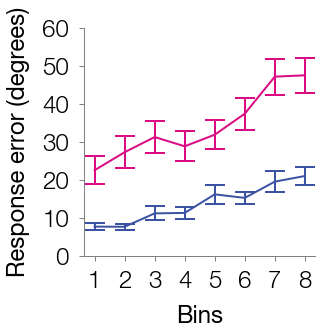

In [82]:
#plt.plot(np.arange(nbins),np.mean(resperr_ltm_origcued_uncued_bin,axis=0),color=col_uncue)
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.errorbar(np.arange(nbins)+1,np.mean(resperr_wm_uncued_bin,axis=0),
             yerr=np.std(resperr_wm_uncued_bin,axis=0)/np.sqrt(nsubj),
             color=col_uncue,capsize=10,lw=2,capthick=2)
ax.errorbar(np.arange(nbins)+1,np.mean(resperr_wm_cued_bin,axis=0),
             yerr=np.std(resperr_wm_cued_bin,axis=0)/np.sqrt(nsubj),
             color=col_cue,capsize=10,lw=2,capthick=2)
prettify_plot(ax,xt=np.arange(nbins)+1,xtl=np.arange(nbins)+1,
             ylim=[0,60],yt=[0,10,20,30,40,50,60],ytl=[0,10,20,30,40,50,60],
             yl='Response error (degrees)',xl='Bins')

## Unprobed items

In [83]:
r = np.empty(nsubj)
m = np.empty(nsubj)
for isubj in range(nsubj):
    r[isubj],p = (pearsonr(ltmdiff_uncued[isubj],ltmdiff_origcued_uncued[isubj]))
    m[isubj],_ = np.polyfit(ltmdiff_uncued[isubj],ltmdiff_origcued_uncued[isubj],1)


p,_ = resampling_statistics(.5*np.log((1+r)/(1-r)),0)
print(np.mean(r,axis=0),bootstrap.ci(data=(r), statfunction=scipy.mean,n_samples=n_its),p) 
p,_ = resampling_statistics(m,0)
print(np.mean(m,axis=0),bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=n_its),p)

0.061112216980384534 [0.02606953 0.1026695 ] 0.00035
0.05752390996126349 [0.02456242 0.09625923] 0.00045


In [84]:
resperr_ltm_origcued_uncued = np.empty(nsubj)
for isubj in range(nsubj):
    resperr_ltm_origcued_uncued[isubj] = np.mean(np.abs(np.ravel(dat_ltm_1a[isubj].ltmresptestimgdiff[dat_ltm_1a[isubj].conditionNum==2])))
    
print("mean unprobed:", np.round(np.mean(resperr_ltm_origcued_uncued,axis=0),decimals=2),np.round(bootstrap.ci(data=(resperr_ltm_origcued_uncued),n_samples=n_its),decimals=2))

pfit = np.zeros((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(np.arange(nbins),resperr_ltm_origcued_uncued_bin[isubj,:],1)

p, _ = resampling_statistics(pfit[:,0],0)
    
print("mean slope", np.round(np.mean(pfit[:,0],axis=0),decimals=2),np.round(bootstrap.ci(data=(pfit[:,0]), n_samples=n_its),decimals=2))
print("stats", p)

mean unprobed: 93.31 [90.8  95.64]
mean slope 1.49 [0.64 2.49]
stats 0.00029


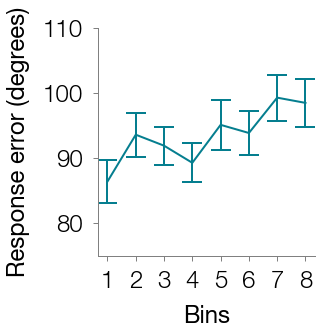

In [85]:
#plot unprobed results 
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.errorbar(np.arange(nbins)+1,np.mean(resperr_ltm_origcued_uncued_bin,axis=0),
             yerr=np.std(resperr_ltm_origcued_uncued_bin,axis=0)/np.sqrt(nsubj),
             color=col_cueunprobed,capsize=10,lw=2,capthick=2)

prettify_plot(ax,xt=np.arange(nbins)+1,xtl=np.arange(nbins)+1,
             ylim=[75,110],yt=[80,90,100,110],ytl=[80,90,100,110],
             yl='Response error (degrees)',xl='Bins')

## Plot results for binning analyses, for all conditions 

cued: blue

uncued: pink

cued-but-unprobed: turquoise

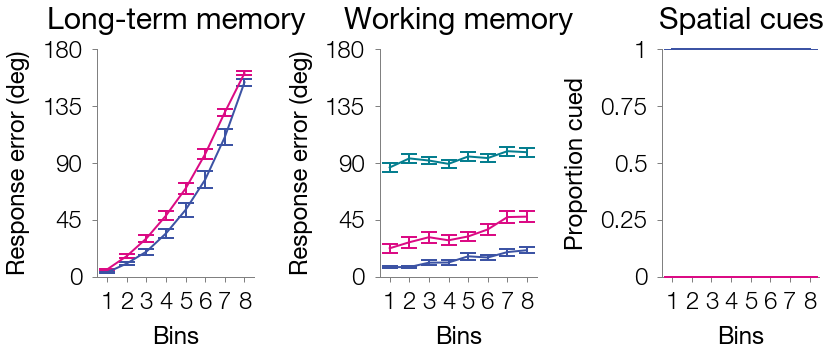

In [86]:
fig,ax = plt.subplots(1,3,figsize=(12,5))
ax[0].errorbar(np.arange(nbins),np.mean(resperr_ltm_cued_bin,axis=0),np.std(resperr_ltm_cued_bin,axis=0)/np.sqrt(nsubj),
               color=col_cue,lw=2,capsize=8,capthick=2,zorder=100)
ax[0].errorbar(np.arange(nbins),np.mean(resperr_ltm_uncued_bin,axis=0),np.std(resperr_ltm_uncued_bin,axis=0)/np.sqrt(nsubj),
               color=col_uncue,lw=2,capsize=8,capthick=2,zorder=100)

ax[1].errorbar(np.arange(nbins),np.mean(resperr_wm_cued_bin,axis=0),np.std(resperr_wm_cued_bin,axis=0)/np.sqrt(nsubj),
               color=col_cue,lw=2,capsize=8,capthick=2,zorder=100)
ax[1].errorbar(np.arange(nbins),np.mean(resperr_wm_uncued_bin,axis=0),np.std(resperr_wm_uncued_bin,axis=0)/np.sqrt(nsubj),
               color=col_uncue,lw=2,capsize=8,capthick=2,zorder=100)
ax[1].errorbar(np.arange(nbins),np.mean(resperr_ltm_origcued_uncued_bin,axis=0),np.std(resperr_ltm_origcued_uncued_bin,axis=0)/np.sqrt(nsubj),
               color=col_cueunprobed,lw=2,capsize=8,capthick=2,zorder=100)

ax[2].errorbar(np.arange(nbins),np.mean(cuedvalidly_cued_bin,axis=0),np.std(cuedvalidly_cued_bin,axis=0)/np.sqrt(nsubj),
               color=col_cue,lw=2,capsize=8,capthick=2,zorder=100,clip_on=False)
ax[2].errorbar(np.arange(nbins),np.mean(cuedvalidly_uncued_bin,axis=0),np.std(cuedvalidly_uncued_bin,axis=0)/np.sqrt(nsubj),
               color=col_uncue,lw=2,capsize=8,capthick=2,zorder=100,clip_on=False)


prettify_plot(ax[0],ylrot=0,xlim=(-.5,nbins-.5),ylim=(0,180),
                 xt=(np.arange(nbins)),xtl=(np.arange(nbins)+1),
                 xl='Bins',yl='Response error (deg)',
                 yt=([0,45,90,135,180]),ytl=([0,45,90,135,180]))

prettify_plot(ax[1],ylrot=0,xlim=(-.5,nbins-.5),ylim=(0,180),
                 xt=(np.arange(nbins)),xtl=(np.arange(nbins)+1),
                 xl='Bins',yl='Response error (deg)',
                 yt=([0,45,90,135,180]),ytl=([0,45,90,135,180]))

prettify_plot(ax[2],ylrot=0,xlim=(-.5,nbins-.5),ylim=(0,1),
                 xt=(np.arange(nbins)),xtl=(np.arange(nbins)+1),
                 xl='Bins',yl='Proportion cued',
                 yt=([0,.25,.5,.75,1]),ytl=([0,.25,.5,.75,1]))


ax[0].set_title('Long-term memory',fontproperties=titleprop,pad=20)
ax[1].set_title('Working memory',fontproperties=titleprop,pad=20)
ax[2].set_title('Spatial cues',fontproperties=titleprop,pad=20)
fig.subplots_adjust(wspace=.8)
plt.show()



# Experiment 1b

In this experiment, we replicate the findings from Experiment 1a, and extend them to look at conditions with a neutral cue, where four dots appeared to indicate the spatial position of all four items but not which one was more likely to be tested

In [88]:
exp_name_1b = 'expt1b'
exp_dir = '../' + exp_name_1b + '/'

subj_name_1b = ['0809181_rtPreStim08','0809182_rtPreStim08','0810181_rtPreStim08',
             '0810182_rtPreStim08','0813181_rtPreStim08','0813182_rtPreStim08',
             '0814181_rtPreStim08','0814182_rtPreStim08','0815181_rtPreStim08',
             '0815182_rtPreStim08','0815183_rtPreStim08','0815184_rtPreStim08',
             '0816182_rtPreStim08','0817181_rtPreStim08','0820181_rtPreStim08',
             '0822181_rtPreStim08','0824181_rtPreStim08','0827181_rtPreStim08',
             '0827183_rtPreStim08','0827184_rtPreStim08','0827185_rtPreStim08',
             '0827186_rtPreStim08','0827187_rtPreStim08','0828181_rtPreStim08']
nsubj = np.size(subj_name_1b)

#load files
dat_wm_1b = {}
dat_ltm_1b = {}
nt_completed = np.empty(nsubj)
for isubj in range(nsubj):
    dat_wm_1b[isubj] = pd.read_csv(exp_dir + subj_name_1b[isubj] +'_wmlog.csv')
    dat_ltm_1b[isubj] = pd.read_csv(exp_dir + subj_name_1b[isubj] +'_ltmlog.csv')
    nt_completed[isubj] = np.shape(dat_wm_1b[isubj])[0]
    
print('# subjects = %d' %nsubj)
print("Avg percent completed %.2f" % (np.round(np.mean(nt_completed/nt_wm)*100,decimals=2)))
print("Range of trials completed %i (min) - %i (max)" %(np.min(nt_completed),np.max(nt_completed)))

# subjects = 24
Avg percent completed 93.75
Range of trials completed 312 (min) - 384 (max)


## Location memory response error

In [89]:
#preallocate empty matrices
resperr_ltm_all = []
resperr_ltm_mean = np.empty(nsubj)
resperr_wm_mean = np.empty(nsubj)

for isubj in range(nsubj):    
    #ltm
    resperr_ltm = dat_ltm_1b[isubj]['ltmresptestimgdiff'][np.logical_or(dat_ltm_1b[isubj]['ltmTrialsOldValidCued']==1,
                                                           dat_ltm_1b[isubj]['ltmTrialsOldInvalidTested']==1)]
    resperr_ltm_all = np.append(resperr_ltm_all,resperr_ltm) #include data from this subject in aggregate data
    resperr_ltm_mean[isubj] = np.mean(np.abs(resperr_ltm))
    
    #ltm
    resperr_wm_mean[isubj] = np.mean(np.abs(dat_wm_1b[isubj].wmresptestimgdiff))

#confidence interval
resperr_ltm_CIs = bootstrap.ci(data=(resperr_ltm_mean), statfunction=scipy.mean,n_samples=n_its)
resperr_wm_CIs = bootstrap.ci(data=(resperr_wm_mean), statfunction=scipy.mean,n_samples=n_its)

#print mean, CIs
print("Mean LTM response error:", np.round(np.mean(resperr_ltm_mean),decimals=2),np.round(resperr_ltm_CIs,decimals=2))
print("Mean WM response error: ", np.round(np.mean(resperr_wm_mean),decimals=2),np.round(resperr_wm_CIs,decimals=2))

Mean LTM response error: 63.72 [58.39 68.5 ]
Mean WM response error:  23.22 [19.8 26.9]


## Relate WM and LTM


In [90]:
#preallocate
cuedvalidly_bin = np.zeros((nsubj,nbins))
resperr_wm_bin = np.zeros((nsubj,nbins))
resperr_ltm_bin = np.zeros((nsubj,nbins))
cuedvalidly = []
wmdiff = []
ltmdiff = []

for isubj in range(nsubj):
    
    #append all trials
    cuedvalidly.append(np.zeros(np.sum(np.logical_or(dat_ltm_1b[isubj].conditionNum==1,dat_ltm_1b[isubj].conditionNum==3))))
    wmdiff.append(np.zeros(np.sum(np.logical_or(dat_ltm_1b[isubj].conditionNum==1,dat_ltm_1b[isubj].conditionNum==3))))
    ltmdiff.append(np.zeros(np.sum(np.logical_or(dat_ltm_1b[isubj].conditionNum==1,dat_ltm_1b[isubj].conditionNum==3))))
        
    count = 0
    for iblock in np.unique(dat_ltm_1b[isubj].block):
        #find trials from this block
        itrials_wm = dat_wm_1b[isubj].block==iblock
        itrials_ltm = np.logical_and(dat_ltm_1b[isubj].block==iblock,np.logical_or(dat_ltm_1b[isubj].conditionNum==1,dat_ltm_1b[isubj].conditionNum==3))

        #find response error for this block's trials
        cuevalid = np.ravel(dat_wm_1b[isubj].cuevalid[itrials_wm])
        respdiff_wm = np.abs(np.ravel(dat_wm_1b[isubj].wmresptestimgdiff[itrials_wm]))
        respdiff_ltm = np.abs(np.ravel(dat_ltm_1b[isubj].ltmresptestimgdiff[itrials_ltm]))
        wmtrialnum_wm = np.ravel(dat_wm_1b[isubj].trial[itrials_wm])
        wmtrialnum_ltm = np.ravel(dat_ltm_1b[isubj].ltmWMtrialNum[itrials_ltm])

        #reorder LTM difference according to wm encoding order
        for itrial in range(np.size(wmtrialnum_ltm)):
            i = np.where(wmtrialnum_wm==wmtrialnum_ltm[itrial])[0]
            cuedvalidly[isubj][count] =(cuevalid[i])
            wmdiff[isubj][count] =(respdiff_wm[i])
            ltmdiff[isubj][count]=(respdiff_ltm[itrial])
            count=count+1
    
    #calculate mean response error in the WM phase
    temp_perc = (np.percentile(ltmdiff[isubj],np.linspace(0,100,(nbins+1),endpoint=True)))
    
    for i,iperc in enumerate(temp_perc[1:]):
        cuedvalidly_bin[isubj,i]=np.mean(cuedvalidly[isubj][np.logical_and(ltmdiff[isubj]<iperc,ltmdiff[isubj]>temp_perc[i])])
        resperr_wm_bin[isubj,i]=np.mean(wmdiff[isubj][np.logical_and(ltmdiff[isubj]<iperc,ltmdiff[isubj]>temp_perc[i])])
        resperr_ltm_bin[isubj,i]= np.mean(ltmdiff[isubj][np.logical_and(ltmdiff[isubj]<iperc,ltmdiff[isubj]>temp_perc[i])])


In [91]:
r = np.empty(nsubj)
for isubj in range(nsubj):
    r[isubj],p = (pearsonr(wmdiff[isubj],ltmdiff[isubj]))
    
print(np.mean(r,axis=0),bootstrap.ci(data=(r), statfunction=scipy.mean,n_samples=n_its)) 

p,_ = resampling_statistics(.5*np.log((1+r)/(1-r)),0)
print(p)

pfit = np.zeros((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(np.arange(nbins),resperr_wm_bin[isubj,:],1)
print('LTM to WM, mean', np.round(np.mean(pfit[:,0],axis=0),decimals=2))
print('LTM to WM, CIs', np.round(bootstrap.ci(data=(pfit[:,0]), statfunction=scipy.mean,n_samples=n_its),decimals=2))
print('LTM to WM, stats', resampling_statistics(pfit[:,0],0))

0.21540209536630128 [0.17203197 0.26379652]
1e-05
LTM to WM, mean 3.54
LTM to WM, CIs [2.84 4.44]
LTM to WM, stats (1e-05, array([3.47873694, 3.92781366, 3.57476821, ..., 3.57286792, 3.24157855,
       4.22505902]))


## Spatial attention results

If cues influence long-term memory, then the response error will be lower for cued vs. uncued items

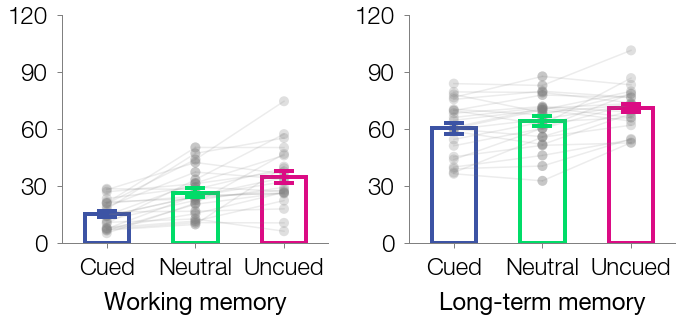

Mean response error:
wm cued:	 15.31 [12.54 18.32]
wm neut:	 26.51 [22.27 31.3 ]
wm uncued:	 34.59 [29.09 41.13]
ltm cued:	 60.39 [54.5  65.75]
ltm neut:	 64.32 [58.59 69.19]
ltm uncued:	 71.12 [66.91 75.93]

Delta response error:
ltm neut vs. cued:	 3.93 [1.05 6.78]
ltm uncued vs. neut:	 6.8 [ 3.28 10.51]

Long-term memory: cued vs uncued
Wilcoxon: t  13.0 p 9.067222017758301e-05
p:  1e-05

Long-term memory: cued vs neut
Wilcoxon: t  68.0 p 0.019136708854110035
p:  0.00364

Long-term memory: neut vs. uncued
Wilcoxon: t  68.0 p 0.019136708854110035
p:  0.00351


0.00351

In [92]:
#preallocate empty matrices
resperr_wm_cue_mean,resperr_wm_uncue_mean,resperr_wm_neut_mean = np.empty(nsubj),np.empty(nsubj),np.empty(nsubj)
resperr_ltm_cue_mean,resperr_ltm_uncue_mean,resperr_ltm_neut_mean = np.empty(nsubj),np.empty(nsubj),np.empty(nsubj)

for isubj in range(nsubj):
    #wm, cued
    resperr_wm_cue = dat_wm_1b[isubj]['wmresptestimgdiff'][np.logical_and(dat_wm_1b[isubj]['cuevalid']==1,dat_wm_1b[isubj]['ncues']==1)]
    resperr_wm_cue_mean[isubj] = np.mean(np.abs(resperr_wm_cue))
    
    #wm, neut
    resperr_wm_neut = dat_wm_1b[isubj]['wmresptestimgdiff'][dat_wm_1b[isubj]['ncues']==4]
    resperr_wm_neut_mean[isubj] = np.mean(np.abs(resperr_wm_neut))
    
    #wm, uncued
    resperr_wm_uncue = dat_wm_1b[isubj]['wmresptestimgdiff'][np.logical_and(dat_wm_1b[isubj]['cuevalid']==0,dat_wm_1b[isubj]['ncues']==1)]
    resperr_wm_uncue_mean[isubj] = np.mean(np.abs(resperr_wm_uncue))
    
    
    ncues_ltm = np.ravel(np.tile(dat_wm_1b[isubj].ncues[dat_wm_1b[isubj].trial==0],(nt_ltm_perblock,1)).T)
    
    #ltm, cued
    resperr_ltm_cue = dat_ltm_1b[isubj]['ltmresptestimgdiff'][np.logical_and(dat_ltm_1b[isubj]['ltmTrialsOldValidCued']==1,ncues_ltm==1)]
    #resperr_ltm_cue_all = np.append(resperr_ltm_cue_all,resperr_ltm_cue) #include data from this subject in aggregate data
    resperr_ltm_cue_mean[isubj] = np.mean(np.abs(resperr_ltm_cue))
    
    #ltm, uncued
    resperr_ltm_uncue = dat_ltm_1b[isubj]['ltmresptestimgdiff'][np.logical_and(dat_ltm_1b[isubj]['ltmTrialsOldInvalidTested']==1,ncues_ltm==1)] 
    #resperr_ltm_uncue_all = np.append(resperr_ltm_uncue_all,resperr_ltm_uncue) #include data from this subject in aggregate data
    resperr_ltm_uncue_mean[isubj] = np.mean(np.abs(resperr_ltm_uncue))
    
    #ltm, uncued
    itrials = np.logical_or(dat_ltm_1b[isubj]['ltmTrialsOldValidCued']==1,dat_ltm_1b[isubj]['ltmTrialsOldInvalidTested']==1)
    resperr_ltm_neut = dat_ltm_1b[isubj]['ltmresptestimgdiff'][np.logical_and(itrials,ncues_ltm==4)] 
    #resperr_ltm_neut_all = np.append(resperr_ltm_neut_all,resperr_ltm_neut) #include data from this subject in aggregate data
    resperr_ltm_neut_mean[isubj] = np.mean(np.abs(resperr_ltm_neut))
    
    
fig,ax = plt.subplots(1,2,figsize=(10,5))

bar_witherror_anddots(ax[0],resperr_wm_cue_mean,resperr_wm_neut_mean,c0=col_cue,c1=col_neut)
bar_witherror_anddots(ax[0],resperr_wm_neut_mean,resperr_wm_uncue_mean,x=[1,2],c0=col_neut,c1=col_uncue)
prettify_plot(ax[0],ylrot=0,xlim=(-.5,2.5),ylim=(0,120),
                 xt=([0,1,2]),xtl=(['Cued','Neutral','Uncued']),
                 xl='Working memory',yl='',
                 yt=([0,30,60,90,120]),ytl=([0,30,60,90,120]))


bar_witherror_anddots(ax[1],resperr_ltm_cue_mean,resperr_ltm_neut_mean,c0=col_cue,c1=col_neut)
bar_witherror_anddots(ax[1],resperr_ltm_neut_mean,resperr_ltm_uncue_mean,x=[1,2],c0=col_neut,c1=col_uncue)
prettify_plot(ax[1],ylrot=0,xlim=(-.5,2.5),ylim=(0,120),
                 xt=([0,1,2]),xtl=(['Cued','Neutral','Uncued']),
                 xl='Long-term memory',yl='',
                 yt=([0,30,60,90,120]),ytl=([0,30,60,90,120]))
plt.show()

#confidence interval
resperr_ltm_cue_CIs = bootstrap.ci(data=(resperr_ltm_cue_mean), statfunction=scipy.mean,n_samples=n_its)
resperr_ltm_neut_CIs = bootstrap.ci(data=(resperr_ltm_neut_mean), statfunction=scipy.mean,n_samples=n_its)
resperr_ltm_uncue_CIs = bootstrap.ci(data=(resperr_ltm_uncue_mean), statfunction=scipy.mean,n_samples=n_its)

#print
print("Mean response error:")
print("wm cued:\t", np.round(np.mean(resperr_wm_cue_mean),decimals=2),np.round(bootstrap.ci(data=(resperr_wm_cue_mean), n_samples=n_its),decimals=2))
print("wm neut:\t", np.round(np.mean(resperr_wm_neut_mean),decimals=2),np.round(bootstrap.ci(data=(resperr_wm_neut_mean), n_samples=n_its),decimals=2))
print("wm uncued:\t",np.round(np.mean(resperr_wm_uncue_mean),decimals=2),np.round(bootstrap.ci(data=(resperr_wm_uncue_mean), n_samples=n_its),decimals=2))

print("ltm cued:\t", np.round(np.mean(resperr_ltm_cue_mean),decimals=2),np.round(resperr_ltm_cue_CIs,decimals=2))
print("ltm neut:\t", np.round(np.mean(resperr_ltm_neut_mean),decimals=2),np.round(resperr_ltm_neut_CIs,decimals=2))
print("ltm uncued:\t",np.round(np.mean(resperr_ltm_uncue_mean),decimals=2),np.round(resperr_ltm_uncue_CIs,decimals=2))

#confidence interval
resperr_ltm_neutvscue_CIs = bootstrap.ci(data=(resperr_ltm_neut_mean-resperr_ltm_cue_mean), statfunction=scipy.mean,n_samples=n_its)
resperr_ltm_uncuevsneut_CIs = bootstrap.ci(data=(resperr_ltm_uncue_mean-resperr_ltm_neut_mean), statfunction=scipy.mean,n_samples=n_its)

#print
print("\nDelta response error:")
print("ltm neut vs. cued:\t", np.round(np.mean(resperr_ltm_neut_mean-resperr_ltm_cue_mean),decimals=2),np.round(resperr_ltm_neutvscue_CIs,decimals=2))
print("ltm uncued vs. neut:\t",np.round(np.mean(resperr_ltm_uncue_mean-resperr_ltm_neut_mean),decimals=2),np.round(resperr_ltm_uncuevsneut_CIs,decimals=2))

#statistics
print('\nLong-term memory: cued vs uncued')#ltm cued vs. uncued
run_stats(resperr_ltm_uncue_mean,resperr_ltm_cue_mean)

#statistics
print('\nLong-term memory: cued vs neut')#ltm cued vs. neut
run_stats(resperr_ltm_neut_mean,resperr_ltm_cue_mean)

#statistics
print('\nLong-term memory: neut vs. uncued')#ltm neut vs. uncued
run_stats(resperr_ltm_neut_mean,resperr_ltm_cue_mean)



# Single cued blocks

In [93]:
#preallocate
cuedvalidly_bin_1 = np.zeros((nsubj,nbins))
resperr_wm_bin_1 = np.zeros((nsubj,nbins))
resperr_ltm_bin_1 = np.zeros((nsubj,nbins))
cuedvalidly = []
wmdiff = []
ltmdiff = []

for isubj in range(nsubj):
    ncues_wm = np.ravel(dat_wm_1b[isubj].ncues)
    ncues_ltm = np.ravel(np.tile(dat_wm_1b[isubj].ncues[dat_wm_1b[isubj].trial==0],(nt_ltm_perblock,1)).T)
        
    #append all trials
    cuedvalidly.append(np.zeros(np.sum(np.logical_and(np.logical_or(dat_ltm_1b[isubj].conditionNum==1,dat_ltm_1b[isubj].conditionNum==3),ncues_ltm==1))))
    wmdiff.append(np.zeros(np.sum(np.logical_and(np.logical_or(dat_ltm_1b[isubj].conditionNum==1,dat_ltm_1b[isubj].conditionNum==3),ncues_ltm==1))))
    ltmdiff.append(np.zeros(np.sum(np.logical_and(np.logical_or(dat_ltm_1b[isubj].conditionNum==1,dat_ltm_1b[isubj].conditionNum==3),ncues_ltm==1))))
        
    count = 0
    for iblock in np.unique(dat_ltm_1b[isubj].block):
        #find trials from this block
        itrials_wm = dat_wm_1b[isubj].block==iblock
        itrials_ltm = np.logical_and(dat_ltm_1b[isubj].block==iblock,np.logical_or(dat_ltm_1b[isubj].conditionNum==1,dat_ltm_1b[isubj].conditionNum==3))

        if ncues_wm[itrials_wm][0]==1:
            #find response error for this block's trials
            cuevalid = np.ravel(dat_wm_1b[isubj].cuevalid[itrials_wm])
            respdiff_wm = np.abs(np.ravel(dat_wm_1b[isubj].wmresptestimgdiff[itrials_wm]))
            respdiff_ltm = np.abs(np.ravel(dat_ltm_1b[isubj].ltmresptestimgdiff[itrials_ltm]))
            wmtrialnum_wm = np.ravel(dat_wm_1b[isubj].trial[itrials_wm])
            wmtrialnum_ltm = np.ravel(dat_ltm_1b[isubj].ltmWMtrialNum[itrials_ltm])

            #reorder LTM difference according to wm encoding order
            for itrial in range(np.size(wmtrialnum_ltm)):
                i = np.where(wmtrialnum_wm==wmtrialnum_ltm[itrial])[0]
                cuedvalidly[isubj][count] =(cuevalid[i])
                wmdiff[isubj][count] =(respdiff_wm[i])
                ltmdiff[isubj][count]=(respdiff_ltm[itrial])
                count=count+1
    
    #calculate mean response error in the WM phase
    temp_perc = (np.percentile(ltmdiff[isubj],np.linspace(0,100,(nbins+1),endpoint=True)))
    
    for i,iperc in enumerate(temp_perc[1:]):
        cuedvalidly_bin_1[isubj,i]=np.mean(cuedvalidly[isubj][np.logical_and(ltmdiff[isubj]<iperc,ltmdiff[isubj]>temp_perc[i])])
        resperr_wm_bin_1[isubj,i]=np.mean(wmdiff[isubj][np.logical_and(ltmdiff[isubj]<iperc,ltmdiff[isubj]>temp_perc[i])])
        resperr_ltm_bin_1[isubj,i]= np.mean(ltmdiff[isubj][np.logical_and(ltmdiff[isubj]<iperc,ltmdiff[isubj]>temp_perc[i])])


In [94]:
r = np.empty(nsubj)
m = np.empty(nsubj)
for isubj in range(nsubj):
    r[isubj],p = (spearmanr(ltmdiff[isubj],wmdiff[isubj]))
    m[isubj],_ = np.polyfit(ltmdiff[isubj],wmdiff[isubj],1)


p,_ = resampling_statistics(.5*np.log((1+r)/(1-r)),0)
print(np.mean(r,axis=0),bootstrap.ci(data=(r), statfunction=scipy.mean,n_samples=n_its),p) 
p,_ = resampling_statistics(m,0)
print(np.mean(m,axis=0),bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=n_its),p)

0.1686284320106243 [0.1262594  0.21805972] 1e-05
0.13639157214232037 [0.10403896 0.17407428] 1e-05


In [95]:
#Calculate slope of q
pfit = np.zeros((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(np.arange(nbins),cuedvalidly_bin_1[isubj,:],1)
print('LTM to spatial attn, mean', np.mean(pfit[:,0],axis=0))
print('LTM to spatial attn, CIs', bootstrap.ci(data=(pfit[:,0]), statfunction=scipy.mean,n_samples=n_its))
print('LTM to spatial attn, stats', resampling_statistics(-1*pfit[:,0],0))

LTM to spatial attn, mean -0.017685394407360316
LTM to spatial attn, CIs [-0.0241302  -0.01175059]
LTM to spatial attn, stats (1e-05, array([0.01913963, 0.01144786, 0.01587695, ..., 0.02058559, 0.01380003,
       0.01700293]))


## Plot binning analysis results

Here, we develop a more parsimonious way to reveal the effects of spatial attention on long-term memory. We use a subsequent memory analysis to examine the effects of spatial attention by examining the proportion cued per bin. 

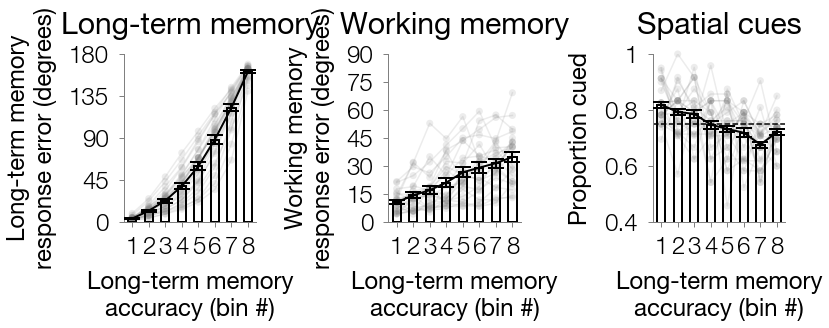

In [96]:
#make figure
fig,ax = plt.subplots(1,3,figsize=(12,5))

s=50
a=.15
#plot ltm 
nbins = np.shape(resperr_ltm_bin)[1]
for ibin in range(nbins):
    ax[0].scatter(np.zeros(nsubj)+ibin,resperr_ltm_bin[:,ibin],s=s,facecolor='gray',edgecolor='None',alpha=a)
ax[0].plot(np.arange(nbins),resperr_ltm_bin.T,color='gray',alpha=a)
ax[0].bar(np.arange(nbins),np.mean(resperr_ltm_bin,axis=0),.5,linewidth=2,facecolor='None',edgecolor='k',zorder=100)
ax[0].errorbar(np.arange(nbins),np.mean(resperr_ltm_bin,axis=0),np.std(resperr_ltm_bin,axis=0)/np.sqrt(nsubj),color='k',
                lw=2,capsize=8,capthick=2,zorder=100)

#plot working memory
for ibin in range(nbins):
    ax[1].scatter(np.zeros(nsubj)+ibin,resperr_wm_bin[:,ibin],s=s,facecolor='gray',edgecolor='None',alpha=a)
ax[1].plot(np.arange(nbins),resperr_wm_bin.T,color='gray',alpha=a)
ax[1].bar(np.arange(nbins),np.mean(resperr_wm_bin,axis=0),.5,linewidth=2,facecolor='None',edgecolor='k',zorder=100)
ax[1].errorbar(np.arange(nbins),np.mean(resperr_wm_bin,axis=0),np.std(resperr_wm_bin,axis=0)/np.sqrt(nsubj),color='k',
                lw=2,capsize=8,capthick=2,zorder=100)

#plot cued proportion 
for ibin in range(nbins):
    ax[2].scatter(np.zeros(nsubj)+ibin,cuedvalidly_bin_1[:,ibin],s=s,facecolor='gray',edgecolor='None',alpha=a,clip_on=False)
ax[2].plot(np.arange(nbins),cuedvalidly_bin_1.T,color='gray',alpha=a)
ax[2].bar(np.arange(nbins),np.mean(cuedvalidly_bin_1,axis=0),.5,linewidth=2,facecolor='None',edgecolor='k',zorder=100)
ax[2].errorbar(np.arange(nbins),np.mean(cuedvalidly_bin_1,axis=0),np.std(cuedvalidly_bin,axis=0)/np.sqrt(nsubj),color='k',
                lw=2,capsize=8,capthick=2,zorder=100)
ax[2].plot([-.5,nbins+.5],[.75,.75],'--',color='k')

prettify_plot(ax[0],ylrot=0,xlim=(-.5,nbins-.5),ylim=(0,180),
                 xt=(np.arange(nbins)),xtl=(np.arange(nbins)+1),
                 xl='Long-term memory\naccuracy (bin #)',yl='Long-term memory\nresponse error (degrees)',
                 yt=([0,45,90,135,180]),ytl=([0,45,90,135,180]))

prettify_plot(ax[1],ylrot=0,xlim=(-.5,nbins-.5),ylim=(0,90),
                 xt=(np.arange(nbins)),xtl=(np.arange(nbins)+1),
                 xl='Long-term memory\naccuracy (bin #)',yl='Working memory\nresponse error (degrees)',
                 yt=([0,15,30,45,60,75,90]),ytl=([0,15,30,45,60,75,90]))

prettify_plot(ax[2],ylrot=0,xlim=(-.5,nbins-.5),ylim=(.4,1),
                 xt=(np.arange(nbins)),xtl=(np.arange(nbins)+1),
                 xl='Long-term memory\naccuracy (bin #)',yl='Proportion cued',
                 yt=([.4,.6,.8,1]),ytl=([.4,.6,.8,1]))

ax[0].set_title('Long-term memory',fontproperties=titleprop,pad=20)
ax[1].set_title('Working memory',fontproperties=titleprop,pad=20)
ax[2].set_title('Spatial cues',fontproperties=titleprop,pad=20)

fig.subplots_adjust(wspace=1)
plt.show()

## Binning analysis results, cued item only

If sustained attention fluctuates even if items were cued, then we will still see the correspondence between long-term memory response error and working memory response error

In [97]:
#preallocate
nbins=8
cuedvalidly_cued_bin = np.zeros((nsubj,nbins))
resperr_wm_cued_bin = np.zeros((nsubj,nbins))
resperr_ltm_cued_bin = np.zeros((nsubj,nbins))
wmdiff_cued = []
ltmdiff_cued = []
cuevalid_cued = []

for isubj in range(nsubj):
    ncues_wm = np.ravel(dat_wm_1b[isubj].ncues)
    ncues_ltm = np.ravel(np.tile(dat_wm_1b[isubj].ncues[dat_wm_1b[isubj].trial==0],(nt_ltm_perblock,1)).T)
    
    #append extra zeros for all trials
    cuevalid_cued.append(np.zeros(np.sum(np.logical_and(dat_ltm_1b[isubj].conditionNum==1,ncues_ltm==1))))
    wmdiff_cued.append(np.zeros(np.sum(np.logical_and(dat_ltm_1b[isubj].conditionNum==1,ncues_ltm==1))))
    ltmdiff_cued.append(np.zeros(np.sum(np.logical_and(dat_ltm_1b[isubj].conditionNum==1,ncues_ltm==1))))
        
    count = 0
    for iblock in np.unique(dat_ltm_1b[isubj].block):
        #find trials from this block
        itrials_wm = np.logical_and(dat_wm_1b[isubj].block==iblock,dat_wm_1b[isubj].cuevalid==1)
        itrials_ltm = np.logical_and(dat_ltm_1b[isubj].block==iblock,dat_ltm_1b[isubj].conditionNum==1)

        if ncues_wm[itrials_wm][0]==1:
            #find response error for this block's trials
            cuevalid = np.ravel(dat_wm_1b[isubj].cuevalid[itrials_wm])
            respdiff_wm = np.abs(np.ravel(dat_wm_1b[isubj].wmresptestimgdiff[itrials_wm]))
            respdiff_ltm = np.abs(np.ravel(dat_ltm_1b[isubj].ltmresptestimgdiff[itrials_ltm]))
            wmtrialnum_wm = np.ravel(dat_wm_1b[isubj].trial[itrials_wm])
            wmtrialnum_ltm = np.ravel(dat_ltm_1b[isubj].ltmWMtrialNum[itrials_ltm])

            for itrial in range(np.size(wmtrialnum_ltm)):
                i = np.where(wmtrialnum_wm==wmtrialnum_ltm[itrial])[0]
                cuevalid_cued[isubj][count] =(cuevalid[i])
                wmdiff_cued[isubj][count] =(respdiff_wm[i])
                ltmdiff_cued[isubj][count]=(respdiff_ltm[itrial])
                count=count+1

    #calculate mean response error in the WM phase
    temp_perc = (np.percentile(ltmdiff_cued[isubj],np.linspace(0,100,(nbins+1),endpoint=True)))
    
    for i,iperc in enumerate(temp_perc[1:]):
        cuedvalidly_cued_bin[isubj,i]=np.mean(cuevalid_cued[isubj][np.logical_and(ltmdiff_cued[isubj]<iperc,ltmdiff_cued[isubj]>temp_perc[i])])
        resperr_wm_cued_bin[isubj,i]=np.mean(wmdiff_cued[isubj][np.logical_and(ltmdiff_cued[isubj]<iperc,ltmdiff_cued[isubj]>temp_perc[i])])
        resperr_ltm_cued_bin[isubj,i]= np.mean(ltmdiff_cued[isubj][np.logical_and(ltmdiff_cued[isubj]<iperc,ltmdiff_cued[isubj]>temp_perc[i])])

In [98]:
r = np.empty(nsubj)
m = np.empty(nsubj)
for isubj in range(nsubj):
    r[isubj],p = (pearsonr(wmdiff_cued[isubj],ltmdiff_cued[isubj]))
    m[isubj],_ = np.polyfit(wmdiff_cued[isubj],ltmdiff_cued[isubj],1)


p,_ = resampling_statistics(.5*np.log((1+r)/(1-r)),0)
print(np.mean(r,axis=0),bootstrap.ci(data=(r), statfunction=scipy.mean,n_samples=n_its),p) 
p,_ = resampling_statistics(m,0)
print(np.mean(m,axis=0),bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=n_its),p)

0.1816501721605893 [0.13722521 0.23527044] 1e-05
0.3509944433375946 [0.26117776 0.44768877] 1e-05


## Binning analysis, uncued items only

Then, we repeat this analysis to examine trial by trial fluctuations of sustained attention, controlling for spatial attention by examining the uncued items only

In [99]:
#preallocate
cuedvalidly_uncued_bin = np.zeros((nsubj,nbins))
resperr_wm_uncued_bin = np.zeros((nsubj,nbins))
resperr_ltm_uncued_bin = np.zeros((nsubj,nbins))
resperr_ltm_origcued_uncued_bin = np.zeros((nsubj,nbins))
wmdiff_uncued = []
ltmdiff_uncued = []
cuevalid_uncued = []
ltmdiff_origcued_uncued = []


for isubj in range(nsubj):
    
    ncues_wm = np.ravel(dat_wm_1b[isubj].ncues)
    ncues_ltm = np.ravel(np.tile(dat_wm_1b[isubj].ncues[dat_wm_1b[isubj].trial==0],(nt_ltm_perblock,1)).T)
    
    #append extra zeros for all trials
    cuevalid_uncued.append(np.zeros(np.sum(np.logical_and(dat_ltm_1b[isubj].conditionNum==3,ncues_ltm==1))))
    wmdiff_uncued.append(np.zeros(np.sum(np.logical_and(dat_ltm_1b[isubj].conditionNum==3,ncues_ltm==1))))
    ltmdiff_uncued.append(np.zeros(np.sum(np.logical_and(dat_ltm_1b[isubj].conditionNum==3,ncues_ltm==1))))
    ltmdiff_origcued_uncued.append(np.zeros(np.sum(np.logical_and(dat_ltm_1b[isubj].conditionNum==3,ncues_ltm==1))))
    
    count = 0
    for iblock in np.unique(dat_ltm_1b[isubj].block):
        #find trials from this block
        itrials_wm = np.logical_and(dat_wm_1b[isubj].block==iblock,dat_wm_1b[isubj].cuevalid==0)
        itrials_ltm = np.logical_and(dat_ltm_1b[isubj].block==iblock,dat_ltm_1b[isubj].conditionNum==3)
        itrials_origcued_ltm = np.logical_and(dat_ltm_1b[isubj].block==iblock,dat_ltm_1b[isubj].conditionNum==2)
        
        if ncues_wm[itrials_wm][0]==1:

            #find response error for this block's trials
            cuevalid = np.ravel(dat_wm_1b[isubj].cuevalid[itrials_wm])
            respdiff_wm = np.abs(np.ravel(dat_wm_1b[isubj].wmresptestimgdiff[itrials_wm]))
            respdiff_ltm = np.abs(np.ravel(dat_ltm_1b[isubj].ltmresptestimgdiff[itrials_ltm]))
            respdiff_ltm_origcued = np.abs(np.ravel(dat_ltm_1b[isubj].ltmresptestimgdiff[itrials_origcued_ltm]))
            wmtrialnum_wm = np.ravel(dat_wm_1b[isubj].trial[itrials_wm])
            wmtrialnum_ltm = np.ravel(dat_ltm_1b[isubj].ltmWMtrialNum[itrials_ltm])
            wmtrialnum_ltm_origcued = np.ravel(dat_ltm_1b[isubj].ltmWMtrialNum[itrials_origcued_ltm])

            for itrial in range(np.size(wmtrialnum_ltm)):
                i = np.where(wmtrialnum_wm==wmtrialnum_ltm[itrial])[0]
                cuevalid_uncued[isubj][count] =(cuevalid[i])
                wmdiff_uncued[isubj][count] =(respdiff_wm[i])
                ltmdiff_uncued[isubj][count]=(respdiff_ltm[itrial])

                i2 = np.where(wmtrialnum_ltm[itrial]==wmtrialnum_ltm_origcued)[0]
                ltmdiff_origcued_uncued[isubj][count] = respdiff_ltm_origcued[i2]
                count=count+1
            
    
    #calculate mean response error in the WM phase
    temp_perc = (np.percentile(ltmdiff_uncued[isubj],np.linspace(0,100,(nbins+1),endpoint=True)))
    
    for i,iperc in enumerate(temp_perc[1:]):
        cuedvalidly_uncued_bin[isubj,i]=np.mean(cuevalid_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        resperr_wm_uncued_bin[isubj,i]=np.mean(wmdiff_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        resperr_ltm_uncued_bin[isubj,i]= np.mean(ltmdiff_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        resperr_ltm_origcued_uncued_bin[isubj,i] = np.mean(ltmdiff_origcued_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        

In [100]:
r = np.empty(nsubj)
m = np.empty(nsubj)
for isubj in range(nsubj):
    r[isubj],p = (spearmanr(wmdiff_uncued[isubj],ltmdiff_uncued[isubj]))
    m[isubj],_ = np.polyfit(wmdiff_uncued[isubj],ltmdiff_uncued[isubj],1)


p,_ = resampling_statistics(r,0)
print(np.mean(r,axis=0),bootstrap.ci(data=(r), statfunction=scipy.mean,n_samples=n_its),p) 
p,_ = resampling_statistics(m,0)
print(np.mean(m,axis=0),bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=n_its),p)

0.1942630828456079 [0.12546143 0.2718012 ] 1e-05
0.24250511576397146 [-0.06912577  0.41837009] 0.02773


## Binning analysis results, uncued item only

If sustained attention fluctuates even if an item was uncued, then we will still see the correspondence between long-term memory response error and working memory response error for uncued items only

In [101]:
pfit = np.zeros((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(np.arange(nbins),resperr_wm_uncued_bin[isubj,:],1)

print(np.round(np.mean(pfit[:,0],axis=0),decimals=2),np.round(bootstrap.ci(data=(pfit[:,0]), n_samples=n_its),decimals=2))
p,_ = resampling_statistics(pfit[:,0],0)
print("stats", p)


4.04 [2.91 5.26]
stats 1e-05


## Neutrally cued items

In [102]:
#preallocate
resperr_wm_bin_4 = np.zeros((nsubj,nbins))
resperr_ltm_bin_4 = np.zeros((nsubj,nbins))
wmdiff = []
ltmdiff = []

for isubj in range(nsubj):
    ncues_wm = np.ravel(dat_wm_1b[isubj].ncues)
    ncues_ltm = np.ravel(np.tile(dat_wm_1b[isubj].ncues[dat_wm_1b[isubj].trial==0],(nt_ltm_perblock,1)).T)
    
    #append all trials
    wmdiff.append(np.zeros(np.sum(np.logical_and(np.logical_or(dat_ltm_1b[isubj].conditionNum==1,dat_ltm_1b[isubj].conditionNum==3),ncues_ltm==4))))
    ltmdiff.append(np.zeros(np.sum(np.logical_and(np.logical_or(dat_ltm_1b[isubj].conditionNum==1,dat_ltm_1b[isubj].conditionNum==3),ncues_ltm==4))))
    
    count = 0
    count2=0
    for iblock in np.unique(dat_ltm_1b[isubj].block):
        #find trials from this block
        itrials_wm = dat_wm_1b[isubj].block==iblock
        itrials_ltm = np.logical_and(dat_ltm_1b[isubj].block==iblock,np.logical_or(dat_ltm_1b[isubj].conditionNum==1,dat_ltm_1b[isubj].conditionNum==3))
        
        if ncues_wm[itrials_wm][0]==4:
            #find response error for this block's trials
            respdiff_wm = np.abs(np.ravel(dat_wm_1b[isubj].wmresptestimgdiff[itrials_wm]))
            respdiff_ltm = np.abs(np.ravel(dat_ltm_1b[isubj].ltmresptestimgdiff[itrials_ltm]))
            
            wmtrialnum_wm = np.ravel(dat_wm_1b[isubj].trial[itrials_wm])
            wmtrialnum_ltm = np.ravel(dat_ltm_1b[isubj].ltmWMtrialNum[itrials_ltm])
            
            #reorder LTM difference according to wm encoding order
            for itrial in range(np.size(wmtrialnum_ltm)):
                i = np.where(wmtrialnum_wm==wmtrialnum_ltm[itrial])[0]
                wmdiff[isubj][count] =(respdiff_wm[i])
                ltmdiff[isubj][count]=(respdiff_ltm[itrial])
                count=count+1

    
    #calculate mean response error in the WM phase
    temp_perc = (np.percentile(ltmdiff[isubj],np.linspace(0,100,(nbins+1),endpoint=True)))
    
    for i,iperc in enumerate(temp_perc[1:]):
        resperr_wm_bin_4[isubj,i]=np.mean(wmdiff[isubj][np.logical_and(ltmdiff[isubj]<iperc,ltmdiff[isubj]>temp_perc[i])])
        resperr_ltm_bin_4[isubj,i]= np.mean(ltmdiff[isubj][np.logical_and(ltmdiff[isubj]<iperc,ltmdiff[isubj]>temp_perc[i])])

In [103]:
r = np.empty(nsubj)
m = np.empty(nsubj)
for isubj in range(nsubj):
    r[isubj],p = (pearsonr(ltmdiff[isubj],wmdiff[isubj]))
    m[isubj],_ = np.polyfit(ltmdiff[isubj],wmdiff[isubj],1)


p,_ = resampling_statistics(r,0)
print(np.mean(r,axis=0),bootstrap.ci(data=(r), statfunction=scipy.mean,n_samples=n_its),p) 
p,_ = resampling_statistics(m,0)
print(np.mean(m,axis=0),bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=n_its),p)

0.2251726202215234 [0.17324913 0.28277887] 1e-05
0.16743577086065664 [0.12806597 0.21982124] 1e-05


## Binning analysis

m_cued 2.43 [1.74 3.28] stats 1e-05
m_uncued 4.04 [2.91 5.27] stats 1e-05
m_neutral 3.8 [2.94 4.89] stats 1e-05


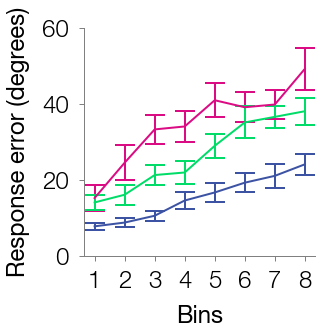

In [104]:
pfit = np.zeros((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(np.arange(nbins),resperr_wm_cued_bin[isubj,:],1)

p,_ = resampling_statistics(pfit[:,0],0)
print("m_cued", np.round(np.mean(pfit[:,0],axis=0),decimals=2),np.round(bootstrap.ci(data=(pfit[:,0]), n_samples=n_its),decimals=2),"stats", p)

pfit = np.zeros((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(np.arange(nbins),resperr_wm_uncued_bin[isubj,:],1)

p,_ = resampling_statistics(pfit[:,0],0)
print("m_uncued", np.round(np.mean(pfit[:,0],axis=0),decimals=2),np.round(bootstrap.ci(data=(pfit[:,0]), n_samples=n_its),decimals=2),"stats", p)

pfit = np.zeros((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(np.arange(nbins),resperr_wm_bin_4[isubj,:],1)

p,_ = resampling_statistics(pfit[:,0],0)
print("m_neutral", np.round(np.mean(pfit[:,0],axis=0),decimals=2),np.round(bootstrap.ci(data=(pfit[:,0]), n_samples=n_its),decimals=2),"stats", p)


fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.errorbar(np.arange(nbins)+1,np.mean(resperr_wm_cued_bin,axis=0),
             yerr=np.std(resperr_wm_cued_bin,axis=0)/np.sqrt(nsubj),
             color=col_cue,capsize=10,lw=2,capthick=2)
ax.errorbar(np.arange(nbins)+1,np.mean(resperr_wm_uncued_bin,axis=0),
             yerr=np.std(resperr_wm_uncued_bin,axis=0)/np.sqrt(nsubj),
             color=col_uncue,capsize=10,lw=2,capthick=2)
ax.errorbar(np.arange(nbins)+1,np.mean(resperr_wm_bin_4,axis=0),
             yerr=np.std(resperr_wm_bin_4,axis=0)/np.sqrt(nsubj),
             color=col_neut,capsize=10,lw=2,capthick=2)
prettify_plot(ax,xt=np.arange(nbins)+1,xtl=np.arange(nbins)+1,
             ylim=[0,60],yt=[0,20,40,60],ytl=[0,20,40,60],
             yl='Response error (degrees)',xl='Bins')

## Attention fluctuations across display, unprobed items

In [108]:
#preallocate
resperr_wm_uncued_bin = np.zeros((nsubj,nbins))
resperr_ltm_uncued_bin = np.zeros((nsubj,nbins))
resperr_ltm_unprobed_bin = np.zeros((nsubj,nbins))
wmdiff_uncued = []
ltmdiff_uncued = []
ltmdiff_unprobed = []


for isubj in range(nsubj):
    
    ncues_wm = np.ravel(dat_wm_1b[isubj].ncues)
    ncues_ltm = np.ravel(np.tile(dat_wm_1b[isubj].ncues[dat_wm_1b[isubj].trial==0],(nt_ltm_perblock,1)).T)
    
    #append extra zeros for all trials
    wmdiff_uncued.append(np.zeros(np.sum(dat_ltm_1b[isubj].conditionNum==3)))
    ltmdiff_uncued.append(np.zeros(np.sum(dat_ltm_1b[isubj].conditionNum==3)))
    ltmdiff_unprobed.append(np.zeros(np.sum(dat_ltm_1b[isubj].conditionNum==3)))
    
    count = 0
    for iblock in np.unique(dat_ltm_1b[isubj].block):
        #find trials from this block
        itrials_wm = np.logical_and(dat_wm_1b[isubj].block==iblock,dat_wm_1b[isubj].cuevalid==0)
        itrials_ltm = np.logical_and(dat_ltm_1b[isubj].block==iblock,dat_ltm_1b[isubj].conditionNum==3)
        itrials_unprobed_ltm = np.logical_and(dat_ltm_1b[isubj].block==iblock,dat_ltm_1b[isubj].conditionNum==2)

        #find response error for this block's trials
        respdiff_wm = np.abs(np.ravel(dat_wm_1b[isubj].wmresptestimgdiff[itrials_wm]))
        respdiff_ltm = np.abs(np.ravel(dat_ltm_1b[isubj].ltmresptestimgdiff[itrials_ltm]))
        respdiff_ltm_unprobed = np.abs(np.ravel(dat_ltm_1b[isubj].ltmresptestimgdiff[itrials_unprobed_ltm]))
        wmtrialnum_wm = np.ravel(dat_wm_1b[isubj].trial[itrials_wm])
        wmtrialnum_ltm = np.ravel(dat_ltm_1b[isubj].ltmWMtrialNum[itrials_ltm])
        wmtrialnum_ltm_unprobed = np.ravel(dat_ltm_1b[isubj].ltmWMtrialNum[itrials_unprobed_ltm])

        for itrial in range(np.size(wmtrialnum_ltm)):
            i = np.where(wmtrialnum_wm==wmtrialnum_ltm[itrial])[0]
            wmdiff_uncued[isubj][count] =(respdiff_wm[i])
            ltmdiff_uncued[isubj][count]=(respdiff_ltm[itrial])

            i2 = np.where(wmtrialnum_ltm[itrial]==wmtrialnum_ltm_unprobed)[0]
            ltmdiff_unprobed[isubj][count] = respdiff_ltm_unprobed[i2]
            count=count+1
            
    
    #calculate mean response error in the WM phase
    temp_perc = (np.percentile(ltmdiff_uncued[isubj],np.linspace(0,100,(nbins+1),endpoint=True)))
    
    for i,iperc in enumerate(temp_perc[1:]):
        resperr_wm_uncued_bin[isubj,i]=np.mean(wmdiff_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        resperr_ltm_uncued_bin[isubj,i]= np.mean(ltmdiff_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        resperr_ltm_unprobed_bin[isubj,i] = np.mean(ltmdiff_unprobed[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        

In [109]:
r = np.empty(nsubj)
m = np.empty(nsubj)
for isubj in range(nsubj):
    r[isubj],p = (pearsonr(ltmdiff_uncued[isubj],ltmdiff_unprobed[isubj]))
    m[isubj],_ = np.polyfit(ltmdiff_uncued[isubj],ltmdiff_unprobed[isubj],1)


p,_ = resampling_statistics(.5*np.log((1+r)/(1-r)),0)
print(np.mean(r,axis=0),bootstrap.ci(data=(r), statfunction=scipy.mean,n_samples=n_its),p) 
p,_ = resampling_statistics(m,0)
print(np.mean(m,axis=0),bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=n_its),p)

0.04603799650190277 [0.00015265 0.09926673] 0.02986
0.04303810552473331 [-0.00061932  0.09412133] 0.03271


mean slope 0.98 [-0.16  2.23]
stats 0.051696


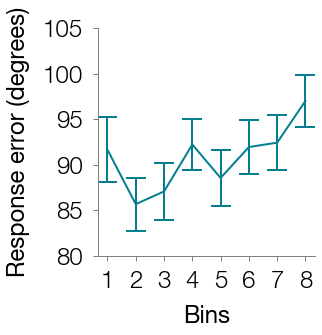

In [110]:
# resperr_ltm_origcued_uncued = np.empty(nsubj)
# for isubj in range(nsubj):
#     ncues_ltm = np.ravel(np.tile(dat_wm_1b[isubj].ncues[dat_wm_1b[isubj].trial==0],(nt_ltm_perblock,1)).T)
#     resperr_ltm_origcued_uncued[isubj] = np.mean(np.abs(np.ravel(dat_ltm_1b[isubj].ltmresptestimgdiff[dat_ltm_1b[isubj].conditionNum==2])))
    
# print("mean unprobed:", np.round(np.mean(resperr_ltm_origcued_uncued,axis=0),decimals=2),np.round(bootstrap.ci(data=(resperr_ltm_origcued_uncued),n_samples=n_its),decimals=2))


pfit = np.zeros((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(np.arange(nbins),resperr_ltm_unprobed_bin[isubj,:],1)

p, _ = resampling_statistics(pfit[:,0],0,nsamples=1000000)
    
print("mean slope", np.round(np.mean(pfit[:,0],axis=0),decimals=2),np.round(bootstrap.ci(data=(pfit[:,0]), n_samples=n_its),decimals=2))
print("stats", p)

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.errorbar(np.arange(nbins)+1,np.mean(resperr_ltm_unprobed_bin,axis=0),
             yerr=np.std(resperr_ltm_unprobed_bin,axis=0)/np.sqrt(nsubj),
             color=col_cueunprobed,capsize=10,lw=2,capthick=2)
prettify_plot(ax,xt=np.arange(nbins)+1,xtl=np.arange(nbins)+1,
             ylim=[80,105],yt=[80,85,90,95,100,105],ytl=[80,85,90,95,100,105],
             yl='Response error (degrees)',xl='Bins')

In [105]:
#preallocate
resperr_wm_uncued_bin = np.zeros((nsubj,nbins))
resperr_ltm_uncued_bin = np.zeros((nsubj,nbins))
resperr_ltm_unprobed_bin = np.zeros((nsubj,nbins))
wmdiff_uncued = []
ltmdiff_uncued = []
ltmdiff_unprobed = []


for isubj in range(nsubj):
    
    ncues_wm = np.ravel(dat_wm_1b[isubj].ncues)
    ncues_ltm = np.ravel(np.tile(dat_wm_1b[isubj].ncues[dat_wm_1b[isubj].trial==0],(nt_ltm_perblock,1)).T)
    
    #append extra zeros for all trials
    wmdiff_uncued.append(np.zeros(np.sum(np.logical_and(dat_ltm_1b[isubj].conditionNum==3,ncues_ltm==1))))
    ltmdiff_uncued.append(np.zeros(np.sum(np.logical_and(dat_ltm_1b[isubj].conditionNum==3,ncues_ltm==1))))
    ltmdiff_unprobed.append(np.zeros(np.sum(np.logical_and(dat_ltm_1b[isubj].conditionNum==3,ncues_ltm==1))))
    
    count = 0
    for iblock in np.unique(dat_ltm_1b[isubj].block):
        
        #find trials from this block
        itrials_wm = np.logical_and(dat_wm_1b[isubj].block==iblock,dat_wm_1b[isubj].cuevalid==0)
        itrials_ltm = np.logical_and(dat_ltm_1b[isubj].block==iblock,dat_ltm_1b[isubj].conditionNum==3)
        itrials_unprobed_ltm = np.logical_and(dat_ltm_1b[isubj].block==iblock,dat_ltm_1b[isubj].conditionNum==2)
        
        if ncues_wm[itrials_wm][0]==1:
            #find response error for this block's trials
            respdiff_wm = np.abs(np.ravel(dat_wm_1b[isubj].wmresptestimgdiff[itrials_wm]))
            respdiff_ltm = np.abs(np.ravel(dat_ltm_1b[isubj].ltmresptestimgdiff[itrials_ltm]))
            respdiff_ltm_unprobed = np.abs(np.ravel(dat_ltm_1b[isubj].ltmresptestimgdiff[itrials_unprobed_ltm]))
            wmtrialnum_wm = np.ravel(dat_wm_1b[isubj].trial[itrials_wm])
            wmtrialnum_ltm = np.ravel(dat_ltm_1b[isubj].ltmWMtrialNum[itrials_ltm])
            wmtrialnum_ltm_unprobed = np.ravel(dat_ltm_1b[isubj].ltmWMtrialNum[itrials_unprobed_ltm])

            for itrial in range(np.size(wmtrialnum_ltm)):
                i = np.where(wmtrialnum_wm==wmtrialnum_ltm[itrial])[0]
                wmdiff_uncued[isubj][count] =(respdiff_wm[i])
                ltmdiff_uncued[isubj][count]=(respdiff_ltm[itrial])

                i2 = np.where(wmtrialnum_ltm[itrial]==wmtrialnum_ltm_unprobed)[0]
                ltmdiff_unprobed[isubj][count] = respdiff_ltm_unprobed[i2]
                count=count+1
            
    
    #calculate mean response error in the WM phase
    temp_perc = (np.percentile(ltmdiff_uncued[isubj],np.linspace(0,100,(nbins+1),endpoint=True)))
    
    for i,iperc in enumerate(temp_perc[1:]):
        resperr_wm_uncued_bin[isubj,i]=np.mean(wmdiff_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        resperr_ltm_uncued_bin[isubj,i]= np.mean(ltmdiff_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        resperr_ltm_unprobed_bin[isubj,i] = np.mean(ltmdiff_unprobed[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        

In [106]:
r = np.empty(nsubj)
m = np.empty(nsubj)
for isubj in range(nsubj):
    r[isubj],p = (pearsonr(ltmdiff_uncued[isubj],wmdiff_uncued[isubj]))
    m[isubj],_ = np.polyfit(ltmdiff_uncued[isubj],wmdiff_uncued[isubj],1)


p,_ = resampling_statistics(.5*np.log((1+r)/(1-r)),0)
print(np.mean(r,axis=0),bootstrap.ci(data=(r), statfunction=scipy.mean,n_samples=n_its),p) 
p,_ = resampling_statistics(m,0)
print(np.mean(m,axis=0),bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=n_its),p)

0.2108123753163873 [0.13741891 0.28965143] 1e-05
0.17308998292006172 [0.11920003 0.24336597] 1e-05


In [107]:
r = np.empty(nsubj)
m = np.empty(nsubj)
for isubj in range(nsubj):
    r[isubj],p = (pearsonr(ltmdiff_uncued[isubj],ltmdiff_unprobed[isubj]))
    m[isubj],_ = np.polyfit(ltmdiff_uncued[isubj],ltmdiff_unprobed[isubj],1)


p,_ = resampling_statistics(.5*np.log((1+r)/(1-r)),0)
print(np.mean(r,axis=0),bootstrap.ci(data=(r), statfunction=scipy.mean,n_samples=n_its),p) 
p,_ = resampling_statistics(m,0)
print(np.mean(m,axis=0),bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=n_its),p)

0.08501657602232894 [0.01544402 0.17039299] 0.01023
0.07979521021548348 [0.01524213 0.15561617] 0.01019


mean slope 1.81 [0.34 3.52]
stats 0.010219


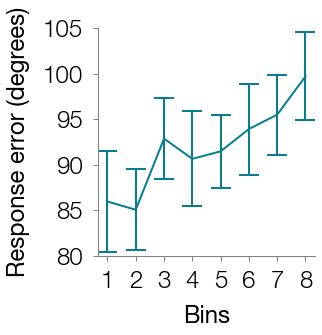

In [300]:
pfit = np.zeros((nsubj,2))
for isubj in range(nsubj):
    pfit[isubj] = np.polyfit(np.arange(nbins),resperr_ltm_unprobed_bin[isubj,:],1)

p, _ = resampling_statistics(pfit[:,0],0,nsamples=1000000)
    
print("mean slope", np.round(np.mean(pfit[:,0],axis=0),decimals=2),np.round(bootstrap.ci(data=(pfit[:,0]), n_samples=n_its),decimals=2))
print("stats", p)

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.errorbar(np.arange(nbins)+1,np.mean(resperr_ltm_unprobed_bin,axis=0),
             yerr=np.std(resperr_ltm_unprobed_bin,axis=0)/np.sqrt(nsubj),
             color=col_cueunprobed,capsize=10,lw=2,capthick=2)
prettify_plot(ax,xt=np.arange(nbins)+1,xtl=np.arange(nbins)+1,
             ylim=[80,105],yt=[80,85,90,95,100,105],ytl=[80,85,90,95,100,105],
             yl='Response error (degrees)',xl='Bins')

In [373]:
#preallocate
resperr_wm_uncued_bin = np.zeros((nsubj,nbins))
resperr_ltm_uncued_bin = np.zeros((nsubj,nbins))
resperr_ltm_unprobed_bin = np.zeros((nsubj,nbins))
wmdiff_uncued = []
ltmdiff_uncued = []
ltmdiff_unprobed = []


for isubj in range(nsubj):
    
    ncues_wm = np.ravel(dat_wm_1b[isubj].ncues)
    ncues_ltm = np.ravel(np.tile(dat_wm_1b[isubj].ncues[dat_wm_1b[isubj].trial==0],(nt_ltm_perblock,1)).T)
    
    #append extra zeros for all trials
    wmdiff_uncued.append(np.zeros(np.sum(np.logical_and(dat_ltm_1b[isubj].conditionNum==3,ncues_ltm==4))))
    ltmdiff_uncued.append(np.zeros(np.sum(np.logical_and(dat_ltm_1b[isubj].conditionNum==3,ncues_ltm==4))))
    ltmdiff_unprobed.append(np.zeros(np.sum(np.logical_and(dat_ltm_1b[isubj].conditionNum==3,ncues_ltm==4))))
    
    count = 0
    for iblock in np.unique(dat_ltm_1b[isubj].block):
        
        #find trials from this block
        itrials_wm = np.logical_and(dat_wm_1b[isubj].block==iblock,dat_wm_1b[isubj].cuevalid==0)
        itrials_ltm = np.logical_and(dat_ltm_1b[isubj].block==iblock,dat_ltm_1b[isubj].conditionNum==3)
        itrials_unprobed_ltm = np.logical_and(dat_ltm_1b[isubj].block==iblock,dat_ltm_1b[isubj].conditionNum==2)
        
        if ncues_wm[itrials_wm][0]==4:
            #find response error for this block's trials
            respdiff_wm = np.abs(np.ravel(dat_wm_1b[isubj].wmresptestimgdiff[itrials_wm]))
            respdiff_ltm = np.abs(np.ravel(dat_ltm_1b[isubj].ltmresptestimgdiff[itrials_ltm]))
            respdiff_ltm_unprobed = np.abs(np.ravel(dat_ltm_1b[isubj].ltmresptestimgdiff[itrials_unprobed_ltm]))
            wmtrialnum_wm = np.ravel(dat_wm_1b[isubj].trial[itrials_wm])
            wmtrialnum_ltm = np.ravel(dat_ltm_1b[isubj].ltmWMtrialNum[itrials_ltm])
            wmtrialnum_ltm_unprobed = np.ravel(dat_ltm_1b[isubj].ltmWMtrialNum[itrials_unprobed_ltm])

            for itrial in range(np.size(wmtrialnum_ltm)):
                i = np.where(wmtrialnum_wm==wmtrialnum_ltm[itrial])[0]
                wmdiff_uncued[isubj][count] =(respdiff_wm[i])
                ltmdiff_uncued[isubj][count]=(respdiff_ltm[itrial])

                i2 = np.where(wmtrialnum_ltm[itrial]==wmtrialnum_ltm_unprobed)[0]
                ltmdiff_unprobed[isubj][count] = respdiff_ltm_unprobed[i2]
                count=count+1
            
    
    #calculate mean response error in the WM phase
    temp_perc = (np.percentile(ltmdiff_uncued[isubj],np.linspace(0,100,(nbins+1),endpoint=True)))
    
    for i,iperc in enumerate(temp_perc[1:]):
        resperr_wm_uncued_bin[isubj,i]=np.mean(wmdiff_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        resperr_ltm_uncued_bin[isubj,i]= np.mean(ltmdiff_uncued[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        resperr_ltm_unprobed_bin[isubj,i] = np.mean(ltmdiff_unprobed[isubj][np.logical_and(ltmdiff_uncued[isubj]<iperc,ltmdiff_uncued[isubj]>temp_perc[i])])
        

In [374]:
r = np.empty(nsubj)
m = np.empty(nsubj)
for isubj in range(nsubj):
    r[isubj],p = (pearsonr(ltmdiff_uncued[isubj],ltmdiff_unprobed[isubj]))
    m[isubj],_ = np.polyfit(ltmdiff_uncued[isubj],ltmdiff_unprobed[isubj],1)


p,_ = resampling_statistics(.5*np.log((1+r)/(1-r)),0)
print(np.mean(r,axis=0),bootstrap.ci(data=(r), statfunction=scipy.mean,n_samples=n_its),p) 
p,_ = resampling_statistics(m,0)
print(np.mean(m,axis=0),bootstrap.ci(data=(m), statfunction=scipy.mean,n_samples=n_its),p)

0.020031372443112896 [-0.04081595  0.0841479 ] 0.25959
0.018346561395967288 [-0.04068115  0.07958588] 0.27602


# Recognition memory

Finally, we'll examine recognitin memory. This project was designed to look at location memory (i.e., response error), but we also collected measures of item recognition

A prime all probed trials:   0.83 [0.76 0.85]
Shapiro-Wilk test statistics=0.675, p=0.000 Sample does not look Gaussian (reject H0)
D'Agostino's K**2 test statistics=40.462, p=0.000 Sample does not look Gaussian (reject H0)
Anderson-Darling test statistic: 1.991, Sample does not look Gaussian (reject H0) sl: 5.000, cv: 0.701


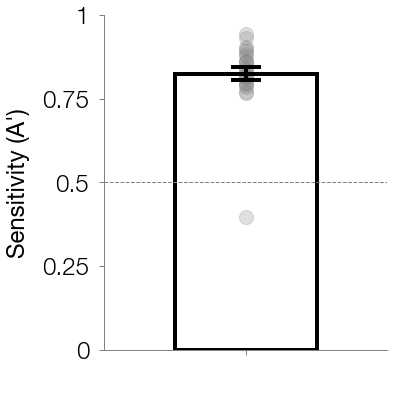


Statistics
ttest: t  39.0680338715122 p 1.558183835290717e-22
nonparametric 1e-05


In [111]:
nsubj_1a = len(dat_wm_1a)
nsubj_1b = len(dat_wm_1b)

#append
dat_wm = {}
dat_ltm = {}
for isubj in range(nsubj):
    if isubj<nsubj_1a:
        dat_wm[isubj] = dat_wm_1a[isubj]
        dat_ltm[isubj] = dat_ltm_1a[isubj]
    else:
        dat_wm[isubj] = dat_wm_1b[isubj-nsubj_1a]
        dat_ltm[isubj] = dat_ltm_1b[isubj-nsubj_1a]
        
#all probed trials

cr = np.zeros(nsubj) #correct rejection
fa = np.zeros(nsubj) #false alarms
h_allold = np.zeros(nsubj) #hit rate
a_allold = np.zeros(nsubj) #aprime
h_probed = np.zeros(nsubj) #hit rate
a_probed = np.zeros(nsubj) #aprime

#calculate recognition memory performance for each subject
for isubj in range(nsubj):
    
    #new trials   
    newtrials = dat_ltm[isubj]['ltmtrialsoldnew']==0
    cr[isubj] = float(np.sum(dat_ltm[isubj]['ltmrating'][newtrials]>1))/np.sum(newtrials)
    fa[isubj] = 1-cr[isubj]

#     #all trials
#     oldtrials = dat_ltm[isubj]['ltmtrialsoldnew']!=0
#     h_allold[isubj] = np.sum(dat_ltm[isubj]['ltmrating'][oldtrials]==1)/float(np.sum(oldtrials))
#     a_allold[isubj] = calculate_aprime(h_allold[isubj],fa[isubj])
    
    #probed trials
    oldtrials_probed = np.logical_or(dat_ltm[isubj]['ltmTrialsOldValidCued']==1,dat_ltm[isubj]['ltmTrialsOldInvalidTested']==1)
    h_probed[isubj] = np.sum(dat_ltm[isubj]['ltmrating'][oldtrials_probed]==1)/float(np.sum(oldtrials_probed))
    a_probed[isubj] = calculate_aprime(h_probed[isubj],fa[isubj])
    

#print aprime
a_probed_CIs = bootstrap.ci(data=(a_probed), statfunction=scipy.mean,n_samples=n_its)
print("A prime all probed trials:  ",np.round(np.mean(a_probed),2),np.round(a_probed_CIs,2))

#test normality
data = a_probed
test_normality(data)

#figure
fig,ax1 = plt.subplots(1,1,figsize=(6,6))
ax1.scatter(np.ones(nsubj),a_probed,s=200,facecolor='gray',alpha=.25,clip_on=False)
ax1.bar(1,np.mean(a_probed),.5,linewidth=4,facecolor='None',edgecolor='k')
ax1.errorbar(1,np.mean(a_probed),np.std(a_probed)/np.sqrt(nsubj),linewidth=4,color='k',capsize=15,capthick=4,zorder=20)
ax1.plot([.5,1.5],[.5,.5],'--',color='gray',lw=1)
prettify_plot(ax1,ylrot=90,xlim=(.5,1.5),
                 ylim=([0,1]),yt=([0,.25,.5,.75,1]),ytl=([0,.25,.5,.75,1]),yl="Sensitivity (A')",
                 xt=([0,1]),xtl=(' ',' '))

plt.show()

#statistics
print("\nStatistics")
t, p = ttest_1samp(data,0)
print("ttest: t ", t, "p", p)
p,data = resampling_statistics(data,.5)
print("nonparametric", p)

## Does recognition memory reflect sustained attention differences?

We'll conduct a subsequent memory analysis based on recognized vs. non recognized items

If so, then the behavioral measure of attention at encoding (working memory response error) should be lower for recognized items

Mean response error:
WM recog:	 16.17 [14.08 18.8 ]
WM unrecog:	 21.41 [18.3  25.99]
WM resp error when recog vs unrecog
Wilcoxon: t  28.0 p 0.0004908249338836073
p:  1e-05


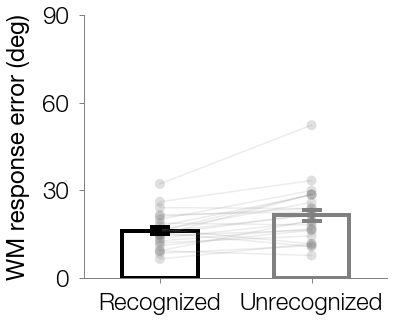

Cued validly:
q recog:	 0.77 [0.76 0.78]
q unrecog:	 0.72 [0.71 0.74]
Cued proportion recog vs unrecog
Wilcoxon: t  44.0 p 0.0024571298322233477
p:  4e-05


4e-05

In [112]:
#preallocate
cuedvalidly_recog = np.zeros(nsubj)
cuedvalidly_unrecog = np.zeros(nsubj)
resperr_wm_recog = np.zeros(nsubj)
resperr_wm_unrecog = np.zeros(nsubj)
cuevalid = []
wmdiff = []
recog = []

for isubj in range(nsubj):
    
    if isubj<nsubj_1a:
        ncues_wm = np.ones(np.size(dat_wm[isubj]['cuevalid']))
        ncues_ltm = np.ones(np.size(dat_ltm[isubj]['ltmresptestimgdiff']))
    else:
        ncues_wm = np.ravel(dat_wm_1b[isubj-nsubj_1a].ncues)#np.ones(np.size(dat_wm[isubj]['cuevalid']))
        ncues_ltm = np.ravel(np.tile(ncues_wm[np.arange(0,np.size(ncues_wm),nt_wm_perblock)],(nt_ltm_perblock,1)).T)
     
    cuevalid.append(np.zeros(np.sum(ncues_wm==1)))
    wmdiff.append(np.zeros(np.sum(ncues_wm==1)))
    recog.append(np.zeros(np.sum(ncues_wm==1)))
    
    count = 0
    for iblock in np.unique(dat_ltm[isubj].block):
        #find trials from this block
        itrials_wm = dat_wm[isubj].block==iblock
        itrials_ltm = np.logical_and(dat_ltm[isubj].block==iblock,np.logical_or(dat_ltm[isubj].conditionNum==1,dat_ltm[isubj].conditionNum==3))
        
        if ncues_wm[itrials_wm][0]==1:
            #find response error for this block's trials
            cuedvalidly_wm = np.ravel(dat_wm[isubj].cuevalid[itrials_wm])
            respdiff_wm = np.ravel(dat_wm[isubj].wmresptestimgdiff[itrials_wm])
            recog_ltm = np.ravel(dat_ltm[isubj].ltmrating[itrials_ltm]==1)
            wmtrialnum_wm = np.ravel(dat_wm[isubj].trial[itrials_wm])
            wmtrialnum_ltm = np.ravel(dat_ltm[isubj].ltmWMtrialNum[itrials_ltm])

            for itrial in range(np.size(wmtrialnum_ltm)):
                i = np.where(wmtrialnum_wm==wmtrialnum_ltm[itrial])[0]
                cuevalid[isubj][count] =(cuedvalidly_wm[i])
                wmdiff[isubj][count] =(respdiff_wm[i])
                recog[isubj][count]=(recog_ltm[itrial])
                count=count+1
            
    cuedvalidly_recog[isubj] = np.mean(cuevalid[isubj][recog[isubj]==1])
    cuedvalidly_unrecog[isubj]= np.mean(cuevalid[isubj][recog[isubj]==0])
            
    resperr_wm_recog[isubj] = np.mean(np.abs(wmdiff[isubj][recog[isubj]==1]))
    resperr_wm_unrecog[isubj]= np.mean(np.abs(wmdiff[isubj][recog[isubj]==0]))
    
#confidence interval
cuedvalidly_recog_CIs = bootstrap.ci(data=(cuedvalidly_recog), statfunction=scipy.mean,n_samples=n_its)
cuedvalidly_unrecog_CIs = bootstrap.ci(data=(cuedvalidly_unrecog), statfunction=scipy.mean,n_samples=n_its)
resperr_wm_recog_CIs = bootstrap.ci(data=(resperr_wm_recog), statfunction=scipy.mean,n_samples=n_its)
resperr_wm_unrecog_CIs = bootstrap.ci(data=(resperr_wm_unrecog), statfunction=scipy.mean,n_samples=n_its)

print("Mean response error:")
print("WM recog:\t", np.round(np.mean(resperr_wm_recog),decimals=2), np.round(resperr_wm_recog_CIs,decimals=2))
print("WM unrecog:\t", np.round(np.mean(resperr_wm_unrecog),decimals=2),np.round(resperr_wm_unrecog_CIs,decimals=2))

#statistics
print('WM resp error when recog vs unrecog')#encoding cued vs. uncued
run_stats(resperr_wm_unrecog,resperr_wm_recog)

fig,ax = plt.subplots(1,1,figsize=(6,5))

bar_witherror_anddots(ax,resperr_wm_recog,resperr_wm_unrecog,c1=[128/255.,128/255.,128/255.])

prettify_plot(ax,ylrot=0,xlim=(-.5,1.5),ylim=(0,90),
                 xt=([0,1]),xtl=(['Recognized','Unrecognized']),yl='WM response error (deg)',
                 yt=([0,30,60,90]),ytl=([0,30,60,90]))
plt.show()

print("Cued validly:")
print("q recog:\t", np.round(np.mean(cuedvalidly_recog),decimals=2), np.round(cuedvalidly_recog_CIs,decimals=2))
print("q unrecog:\t", np.round(np.mean(cuedvalidly_unrecog),decimals=2),np.round(cuedvalidly_unrecog_CIs,decimals=2))

#statistics
print('Cued proportion recog vs unrecog')#encoding cued vs. uncued
run_stats(cuedvalidly_recog,cuedvalidly_unrecog)

## Does recognition memory reflect spatial attention differences?

We'll examine whether spatial attention and recognition memory are related, by looking at whether the recognition memory is better for cued vs. uncued items

Hit rate cued:   0.5 [0.44 0.57]
Hit rate uncued: 0.45 [0.39 0.52]
Wilcoxon: t  39.0 p 0.0015169116773216492
p:  2e-05
A prime cued:   0.83 [0.76 0.86]
A prime uncued: 0.81 [0.76 0.84]
Wilcoxon: t  55.0 p 0.006641885476426627
p:  0.00503


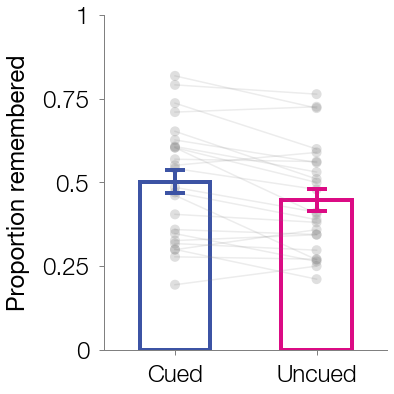

In [113]:
#cued & uncued trials separately

cr, fa= np.zeros(nsubj), np.zeros(nsubj)
h_cued,a_cued = np.zeros(nsubj),np.zeros(nsubj)
h_uncued,a_uncued = np.zeros(nsubj),np.zeros(nsubj)

#calculate recognition memory performance for each subject
for isubj in range(nsubj):
    
    if isubj<nsubj_1a:
        ncues_wm = np.ones(np.size(dat_wm[isubj]['cuevalid']))
        ncues_ltm = np.ones(np.size(dat_ltm[isubj]['ltmresptestimgdiff']))
    else:
        ncues_wm = np.ravel(dat_wm_1b[isubj-nsubj_1a].ncues)#np.ones(np.size(dat_wm[isubj]['cuevalid']))
        ncues_ltm = np.ravel(np.tile(ncues_wm[np.arange(0,np.size(ncues_wm),nt_wm_perblock)],(nt_ltm_perblock,1)).T)
     
    #new trials   
    newtrials = dat_ltm[isubj]['ltmtrialsoldnew']==0
    cr[isubj] = float(np.sum(dat_ltm[isubj]['ltmrating'][newtrials]>1))/np.sum(newtrials)
    fa[isubj] = 1-cr[isubj]

    #cued trials  
    trials_ret_cued =  np.logical_and(dat_ltm[isubj]['ltmTrialsOldValidCued']==1,ncues_ltm==1)
    h_cued[isubj] = np.sum(dat_ltm[isubj]['ltmrating'][trials_ret_cued]==1)/float(np.sum(trials_ret_cued))
    a_cued[isubj] = calculate_aprime(h_cued[isubj],fa[isubj])    

    #uncued trials
    trials_ret_uncued =  np.logical_and(dat_ltm[isubj]['ltmTrialsOldInvalidTested']==1,ncues_ltm==1)
    h_uncued[isubj] = np.sum(dat_ltm[isubj]['ltmrating'][trials_ret_uncued]==1)/float(np.sum(trials_ret_uncued))
    a_uncued[isubj] = calculate_aprime(h_uncued[isubj],fa[isubj])
    
#confidence intervals
a_cued_CIs = bootstrap.ci(data=(a_cued), statfunction=scipy.mean,n_samples=n_its)
a_uncued_CIs = bootstrap.ci(data=(a_uncued), statfunction=scipy.mean,n_samples=n_its)
h_cued_CIs = bootstrap.ci(data=(h_cued), statfunction=scipy.mean,n_samples=n_its)
h_uncued_CIs = bootstrap.ci(data=(h_uncued), statfunction=scipy.mean,n_samples=n_its)

print("Hit rate cued:  ", np.round(np.mean(h_cued),2),np.round(h_cued_CIs,2))
print("Hit rate uncued:", np.round(np.mean(h_uncued),2),np.round(h_uncued_CIs,2))

#statistics hit rate
run_stats(h_cued,h_uncued)

print("A prime cued:  ",np.round(np.mean(a_cued),2),np.round(a_cued_CIs,2))
print("A prime uncued:", np.round(np.mean(a_uncued),2),np.round(a_uncued_CIs,2))

#statistics a prime
run_stats(a_cued,a_uncued)

fig,ax = plt.subplots(1,1,figsize=(6,6))

bar_witherror_anddots(ax,h_cued,h_uncued,c0=col_cue,c1=col_uncue)


prettify_plot(ax,ylrot=90,xlim=(-.5,1.5),
                 ylim=([0,1]),yt=([0,.25,.5,.75,1]),ytl=([0,.25,.5,.75,1]),yl='Proportion remembered',
                 xt=([0,1]),xtl=('Cued','Uncued'))

plt.show()

## Does recognition memory reflect sustained attention, even if we control for spatial attention? 

We'll conduct a subsequent memory analysis based on recognized vs. non recognized items separately for cued and uncued items 

If so, then the behavioral measure of attention at encoding (working memory response error) should be lower for recognized items for both cued and uncued items

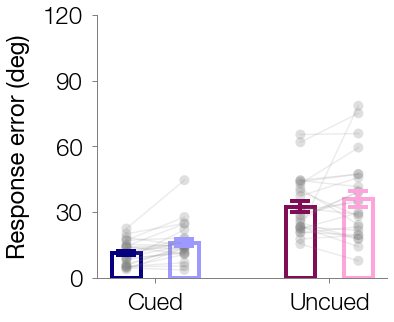

CUED Mean response error:
wm recog:	 11.33 [ 9.31 13.56]
wm unrecog:	 16.1 [13.48 20.41]
wm, diff:	 4.77 [2.8 7.5]
Wilcoxon: t  30.0 p 0.0006067668456360628
p:  1e-05

UNCUED Mean response error:
wm recog:	 32.55 [28.05 38.54]
wm unrecog:	 35.96 [29.34 44.39]
wm, diff:	 3.41 [-0.614 11.349]
Wilcoxon: t  114.0 p 0.3036811097223192
p:  0.09991


0.09991

In [114]:
resperr_wm_cue_recog = np.zeros(nsubj)
resperr_wm_cue_unrecog = np.zeros(nsubj)
resperr_wm_uncue_recog = np.zeros(nsubj)
resperr_wm_uncue_unrecog = np.zeros(nsubj)
resperr_wm_cue = []
resperr_wm_uncue = []
h_ltm_cue = []
h_ltm_uncue = []
for isubj in range(nsubj):
    if isubj<nsubj_1a:
        ncues_wm = np.ones(np.size(dat_wm[isubj]['cuevalid']))
        ncues_ltm = np.ones(np.size(dat_ltm[isubj]['ltmresptestimgdiff']))
    else:
        ncues_wm = np.ravel(dat_wm_1b[isubj-nsubj_1a].ncues)#np.ones(np.size(dat_wm[isubj]['cuevalid']))
        ncues_ltm = np.ravel(np.tile(ncues_wm[np.arange(0,np.size(ncues_wm),nt_wm_perblock)],(nt_ltm_perblock,1)).T)
     
    resperr_wm_cue.append(np.zeros(np.sum(np.logical_and(ncues_ltm==1,dat_ltm[isubj].conditionNum==1))))
    h_ltm_cue.append(np.zeros(np.sum(np.logical_and(ncues_ltm==1,dat_ltm[isubj].conditionNum==1))))
    
    resperr_wm_uncue.append(np.zeros(np.sum(np.logical_and(ncues_ltm==1,dat_ltm[isubj].conditionNum==3))))
    h_ltm_uncue.append(np.zeros(np.sum(np.logical_and(ncues_ltm==1,dat_ltm[isubj].conditionNum==3))))
    
    count_cue = 0
    count_uncue = 0
    for iblock in np.unique(dat_ltm[isubj].block):
        #find trials from this block
        itrials_wm = dat_wm[isubj].block==iblock
        itrials_ltm = dat_ltm[isubj].block==iblock
        
        if ncues_wm[itrials_wm][0]==1:
        
            respdiff_wm = np.ravel(dat_wm[isubj].wmresptestimgdiff[itrials_wm])
            h_ltm = np.ravel(dat_ltm[isubj].ltmrating[itrials_ltm]==1)

            #find old validly cued trials
            testimgtrials = dat_ltm[isubj].conditionNum[itrials_ltm]==1

            #find the wm trial num for the tested trials
            wmtrialnum_testimgtrials = np.ravel(dat_ltm[isubj].ltmWMtrialNum[itrials_ltm][testimgtrials])

            for itrial in range(np.sum(testimgtrials)):
                temp_wmtrialnum = [dat_wm[isubj].trial[itrials_wm]==wmtrialnum_testimgtrials[itrial]]
                #print(np.ravel(temp_wmtrialnum),np.where(np.ravel(temp_wmtrialnum))[0][0])
                resperr_wm_cue[isubj][count_cue] =np.abs(respdiff_wm[np.where(np.ravel(temp_wmtrialnum))[0][0]])
                h_ltm_cue[isubj][count_cue]=np.abs(h_ltm[testimgtrials][itrial])
                count_cue=count_cue+1

            #find old validly cued trials
            testimgtrials = dat_ltm[isubj].conditionNum[itrials_ltm]==3

            #find the wm trial num for the tested trials
            wmtrialnum_testimgtrials = np.ravel(dat_ltm[isubj].ltmWMtrialNum[itrials_ltm][testimgtrials])

            for itrial in range(np.sum(testimgtrials)):
                temp_wmtrialnum = [dat_wm[isubj].trial[itrials_wm]==wmtrialnum_testimgtrials[itrial]]
                resperr_wm_uncue[isubj][count_uncue] =np.abs(respdiff_wm[np.where(np.ravel(temp_wmtrialnum))[0][0]])
                h_ltm_uncue[isubj][count_uncue] =np.abs(h_ltm[testimgtrials][itrial])
                count_uncue=count_uncue+1    
            
    resperr_wm_cue_recog[isubj] = np.mean(resperr_wm_cue[isubj][h_ltm_cue[isubj]==1])
    resperr_wm_cue_unrecog[isubj]= np.mean(resperr_wm_cue[isubj][h_ltm_cue[isubj]==0])

    resperr_wm_uncue_recog[isubj] = np.mean(resperr_wm_uncue[isubj][h_ltm_uncue[isubj]==1])
    resperr_wm_uncue_unrecog[isubj]= np.mean(resperr_wm_uncue[isubj][h_ltm_uncue[isubj]==0])

    
fig,ax = plt.subplots(1,1,figsize=(6,5))


#cued images
bar_witherror_anddots(ax,resperr_wm_cue_recog,resperr_wm_cue_unrecog,c0=col_cue_acc,c1=col_cue_inacc)
bar_witherror_anddots(ax,resperr_wm_uncue_recog,resperr_wm_uncue_unrecog,x=[3,4],c0=col_uncue_acc,c1=col_uncue_inacc)

prettify_plot(ax,ylrot=0,xlim=(-.5,4.5),ylim=(0,120),
                 xt=([.5,3.5]),xtl=(['Cued','Uncued']),yl='Response error (deg)',
                 yt=([0,30,60,90,120]),ytl=([0,30,60,90,120]))

plt.show()


#confidence interval
resperr_wm_cue_recog_CIs = bootstrap.ci(data=(resperr_wm_cue_recog), statfunction=scipy.mean,n_samples=n_its)
resperr_wm_cue_unrecog_CIs = bootstrap.ci(data=(resperr_wm_cue_unrecog), statfunction=scipy.mean,n_samples=n_its)
resperr_wm_cue_diff_CIs = bootstrap.ci(data=(resperr_wm_cue_unrecog-resperr_wm_cue_recog), statfunction=scipy.mean,n_samples=n_its)

resperr_wm_uncue_recog_CIs = bootstrap.ci(data=(resperr_wm_uncue_recog), statfunction=scipy.mean,n_samples=n_its)
resperr_wm_uncue_unrecog_CIs = bootstrap.ci(data=(resperr_wm_uncue_unrecog), statfunction=scipy.mean,n_samples=n_its)
resperr_wm_uncue_diff_CIs = bootstrap.ci(data=(resperr_wm_uncue_unrecog-resperr_wm_uncue_recog), statfunction=scipy.mean,n_samples=n_its)

print("CUED Mean response error:")
print("wm recog:\t", np.round(np.mean(resperr_wm_cue_recog),decimals=2), np.round(resperr_wm_cue_recog_CIs,decimals=2))
print("wm unrecog:\t", np.round(np.mean(resperr_wm_cue_unrecog),decimals=2),np.round(resperr_wm_cue_unrecog_CIs,decimals=2))
print("wm, diff:\t",np.round(np.mean(resperr_wm_cue_unrecog-resperr_wm_cue_recog),decimals=2),
      np.round(resperr_wm_cue_diff_CIs,decimals=2))

#statistics
run_stats(resperr_wm_cue_unrecog,resperr_wm_cue_recog)

print("\nUNCUED Mean response error:")
print("wm recog:\t", np.round(np.mean(resperr_wm_uncue_recog),decimals=2), np.round(resperr_wm_uncue_recog_CIs,decimals=2))
print("wm unrecog:\t", np.round(np.mean(resperr_wm_uncue_unrecog),decimals=2),np.round(resperr_wm_uncue_unrecog_CIs,decimals=2))
print("wm, diff:\t",np.round(np.mean(resperr_wm_uncue_unrecog-resperr_wm_uncue_recog),decimals=2),
      np.round(resperr_wm_uncue_diff_CIs,decimals=3))

#statistics
run_stats(resperr_wm_uncue_unrecog,resperr_wm_uncue_recog)



## Does recognition memory reflect sustained attention differences, for items that were cued but not probed

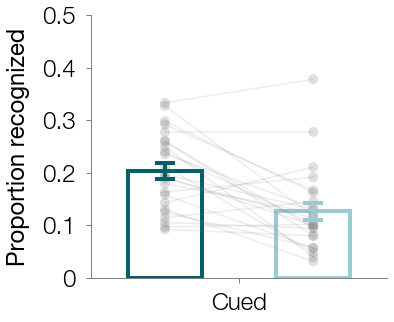

ORIG CUED UNPROBED RESPERR CONDITIONED ON PROBED ITEM RECOGNITION
93.35782770820367 [90.2422687  96.29798694]
92.77192461570257 [89.41449975 96.05283254]
Wilcoxon: t  148.0 p 0.954431397113681
p:  0.60238
ORIG CUED UNPROBED RECOG CONDITIONED ON PROBED ITEM RECOGNITION
0.20296896244363968 [0.17448648 0.23273688]
0.12646463661159205 [0.10181742 0.16609089]
Wilcoxon: t  26.0 p 0.0006580763435422673
p:  1e-05


1e-05

In [115]:
#preallocate
nbins=8
recog_uncued = []
recog_origcued_uncued = []
ltmdiff_origcued_uncued = []
resperr_ltm_origcued_uncuedrecog = np.zeros((nsubj))
recog_ltm_origcued_uncuedrecog = np.zeros((nsubj))
resperr_ltm_origcued_uncuedunrecog = np.zeros((nsubj))
recog_ltm_origcued_uncuedunrecog = np.zeros((nsubj))

for isubj in range(nsubj):
    
    if isubj<nsubj_1a:
        ncues_wm = np.ones(np.size(dat_wm[isubj]['cuevalid']))
        ncues_ltm = np.ones(np.size(dat_ltm[isubj]['ltmresptestimgdiff']))
    else:
        ncues_wm = np.ravel(dat_wm_1b[isubj-nsubj_1a].ncues)#np.ones(np.size(dat_wm[isubj]['cuevalid']))
        ncues_ltm = np.ravel(np.tile(ncues_wm[np.arange(0,np.size(ncues_wm),nt_wm_perblock)],(nt_ltm_perblock,1)).T)
     
    #append extra zeros for all trials
    recog_uncued.append(np.zeros(np.sum(np.logical_and(dat_ltm[isubj].conditionNum==3,ncues_ltm==1))))
    recog_origcued_uncued.append(np.zeros(np.sum(np.logical_and(dat_ltm[isubj].conditionNum==3,ncues_ltm==1))))
    ltmdiff_origcued_uncued.append(np.zeros(np.sum(np.logical_and(dat_ltm[isubj].conditionNum==3,ncues_ltm==1))))
    
    count = 0
    for iblock in np.unique(dat_ltm[isubj].block):
        #find trials from this block
        itrials_ltm = np.logical_and(dat_ltm[isubj].block==iblock,dat_ltm[isubj].conditionNum==3)
        itrials_origcued_ltm = np.logical_and(dat_ltm[isubj].block==iblock,dat_ltm[isubj].conditionNum==2)
        
        if ncues_ltm[itrials_ltm][0]==1:
            #find response error for this block's trials
            h_ltm = np.ravel(dat_ltm[isubj].ltmrating[itrials_ltm]==1)
            h_ltm_origcued = np.ravel(dat_ltm[isubj].ltmrating[itrials_origcued_ltm]==1)
            respdiff_ltm_origcued = np.abs(np.ravel(dat_ltm[isubj].ltmresptestimgdiff[itrials_origcued_ltm]))
            wmtrialnum_ltm = np.ravel(dat_ltm[isubj].ltmWMtrialNum[itrials_ltm])
            wmtrialnum_ltm_origcued = np.ravel(dat_ltm[isubj].ltmWMtrialNum[itrials_origcued_ltm])

            for itrial in range(np.size(wmtrialnum_ltm)):
                #i = np.where(wmtrialnum_wm==wmtrialnum_ltm[itrial])[0]
                recog_uncued[isubj][count]=(h_ltm[itrial])

                i2 = np.where(wmtrialnum_ltm[itrial]==wmtrialnum_ltm_origcued)[0]
                recog_origcued_uncued[isubj][count] = h_ltm_origcued[i2]
                ltmdiff_origcued_uncued[isubj][count] = respdiff_ltm_origcued[i2]
                count=count+1
            
    
    resperr_ltm_origcued_uncuedrecog[isubj] = np.mean(ltmdiff_origcued_uncued[isubj][recog_uncued[isubj]==1])
    recog_ltm_origcued_uncuedrecog[isubj]= np.mean(recog_origcued_uncued[isubj][recog_uncued[isubj]==1])
    resperr_ltm_origcued_uncuedunrecog[isubj] = np.mean(ltmdiff_origcued_uncued[isubj][recog_uncued[isubj]==0])
    recog_ltm_origcued_uncuedunrecog[isubj]= np.mean(recog_origcued_uncued[isubj][recog_uncued[isubj]==0])

resperr_ltm_origcued_uncuedrecog_CIs = bootstrap.ci(data=(resperr_ltm_origcued_uncuedrecog), statfunction=scipy.mean,n_samples=n_its)
resperr_ltm_origcued_uncuedunrecog_CIs = bootstrap.ci(data=(resperr_ltm_origcued_uncuedunrecog), statfunction=scipy.mean,n_samples=n_its)
resperr_ltm_origcued_uncuedrecogdiff_CIs = bootstrap.ci(data=(resperr_ltm_origcued_uncuedrecog-resperr_ltm_origcued_uncuedunrecog), statfunction=scipy.mean,n_samples=n_its)

recog_ltm_origcued_uncuedrecog_CIs = bootstrap.ci(data=(recog_ltm_origcued_uncuedrecog), statfunction=scipy.mean,n_samples=n_its)
recog_ltm_origcued_uncuedunrecog_CIs = bootstrap.ci(data=(recog_ltm_origcued_uncuedunrecog), statfunction=scipy.mean,n_samples=n_its)
recog_ltm_origcued_uncuedunrecogdiff_CIs = bootstrap.ci(data=(recog_ltm_origcued_uncuedunrecog-recog_ltm_origcued_uncuedrecog), statfunction=scipy.mean,n_samples=n_its)

fig,ax = plt.subplots(1,1,figsize=(6,5))
bar_witherror_anddots(ax,recog_ltm_origcued_uncuedrecog,recog_ltm_origcued_uncuedunrecog,c0=col_cueunprobe_acc,c1=col_cueunprobe_inacc)

prettify_plot(ax,ylrot=0,xlim=(-.5,1.5),ylim=(0,0.5),
                 xt=([.5,3.5]),xtl=(['Cued','Uncued']),yl='Proportion recognized',
                 yt=([0,.1,.2,.3,.4,.5]),ytl=([0,.1,.2,.3,.4,.5]))

plt.show()

print("ORIG CUED UNPROBED RESPERR CONDITIONED ON PROBED ITEM RECOGNITION")
print(np.mean(resperr_ltm_origcued_uncuedrecog),resperr_ltm_origcued_uncuedrecog_CIs)
print(np.mean(resperr_ltm_origcued_uncuedunrecog),resperr_ltm_origcued_uncuedunrecog_CIs)
run_stats(resperr_ltm_origcued_uncuedunrecog,resperr_ltm_origcued_uncuedrecog)

print("ORIG CUED UNPROBED RECOG CONDITIONED ON PROBED ITEM RECOGNITION")
print(np.mean(recog_ltm_origcued_uncuedrecog),recog_ltm_origcued_uncuedrecog_CIs)
print(np.mean(recog_ltm_origcued_uncuedunrecog),recog_ltm_origcued_uncuedunrecog_CIs)
run_stats(recog_ltm_origcued_uncuedrecog,recog_ltm_origcued_uncuedunrecog)
    